# Model Validation and coefficient calculation

Marc Pérez  
May 22, 2025

In [ ]:

library(multcomp)


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: 'TH.data'

The following object is masked from 'package:MASS':

    geyser

Loading required package: carData

Loading required package: Matrix


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loading required package: ggpp

Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2


Attaching package: 'ggpp'

The following object is masked from 'package:ggplot2':

    annotate


Attaching package: 'nlme'

The following object is masked from 'package:lme4':

    lmList


Attaching package: 'dplyr'

The following object is masked from 'package:kableExtra':

    group_rows

The following object is masked from 'package:nlme':

    collapse

The following object is masked from 'package:car':

    recode

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'MuMIn':
  method        from 
  nobs.multinom broom
  nobs.fitdistr broom


Attaching package: 'sjmisc'

The following object is masked from 'package:tidyr':

    replace_na

# Results

The results are presented in three main parts. First, the development and validation of the phosphorus (P) desorption kinetic model are detailed, justifying the final modeling approach. Second, the descriptive trends of both agronomic outcomes and soil P parameters in response to long-term fertilization and site differences are explored visually. Finally, the predictive power of the kinetic and standard P parameters is formally evaluated using linear mixed-effects models.

## Establishment of the P-Desorption Kinetic Model

The primary goal was to derive two key parameters for each soil sample: the desorbable P pool ($P_{desorb}$) and the rate constant ($k$). The analysis proceeded in two stages: an initial test of a linearized model, followed by the implementation of a more robust non-linear model.

### Initial Approach: Linearized Model

Following the conceptual framework of Flossmann and Richter (1982), the first-order kinetic equation was linearized to the form $ln(1 - P/P_{desorb}) = -kt$. For this approach, the asymptote ($P_{desorb}$) was not fitted but was calculated beforehand as the difference between Olsen-P and water-soluble P. A linear model was then fitted to the transformed data for each sample.

`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

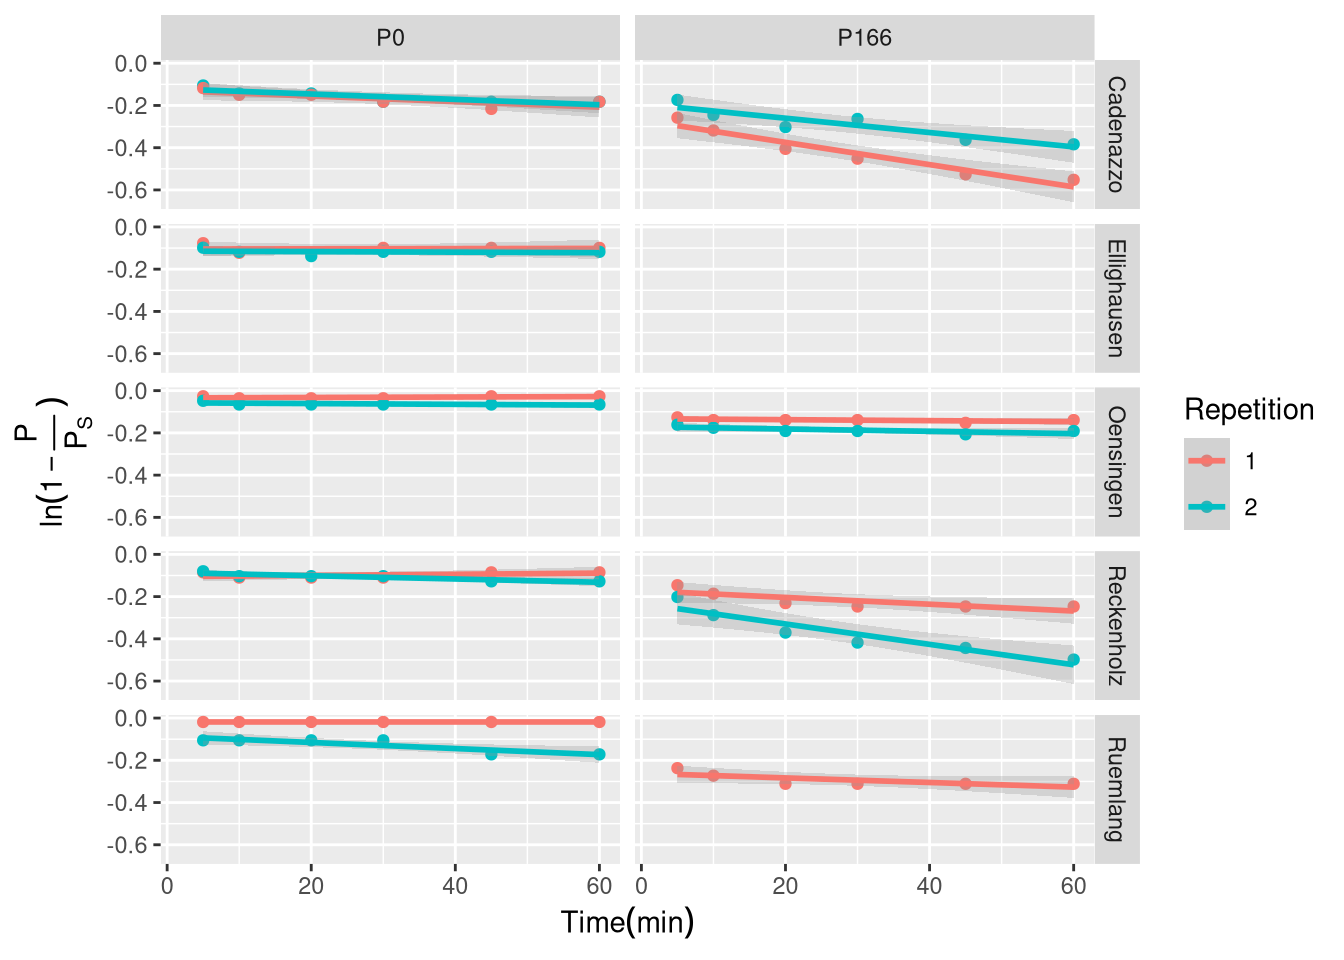

In [ ]:

# This is a placeholder for your code from pretest.qmd
 ggplot(d[d$Treatment!="P100"&(d$Repetition==1|d$Repetition==2),], aes(y=Y1, x=t.min., col = Repetition)) +
   geom_point() +
   facet_grid(Site ~ Treatment) +
   labs(x=TeX("$Time (min)$"),
        y=TeX("$ln(1-\\frac{P}{P_S})$")) +
   geom_smooth(method="lm", alpha = 0.3)


*(Placeholder for the linearized model plot)*

The results of this linearized approach were inconsistent (Figure X.1). While some samples showed a reasonable linear trend, many exhibited significant deviations, particularly a curvilinear pattern. Furthermore, the model required the intercept to be fixed at zero, but the statistical summary of the fitted models (`lmList`) showed that the estimated intercepts were often significantly different from zero (p \< 0.05). For example, the sample `Cadenazzo_P166_1` had a highly significant intercept of -0.27 (p \< 0.001). This systematic deviation from the model’s core assumption indicated that this linearized approach, which relied on an externally estimated asymptote, was not robust for this dataset.

### Final Approach: Non-Linear Model

Given the limitations of the linearized method, a direct non-linear modeling approach was adopted to estimate both $P_{desorb}$ and $k$ simultaneously from the untransformed data. The model $P(t) = P_{desorb} \times (1 - e^{-k \times t'})$ was fitted to each sample’s desorption curve.

= start): singular gradient

ℹ Please use `linewidth` instead.

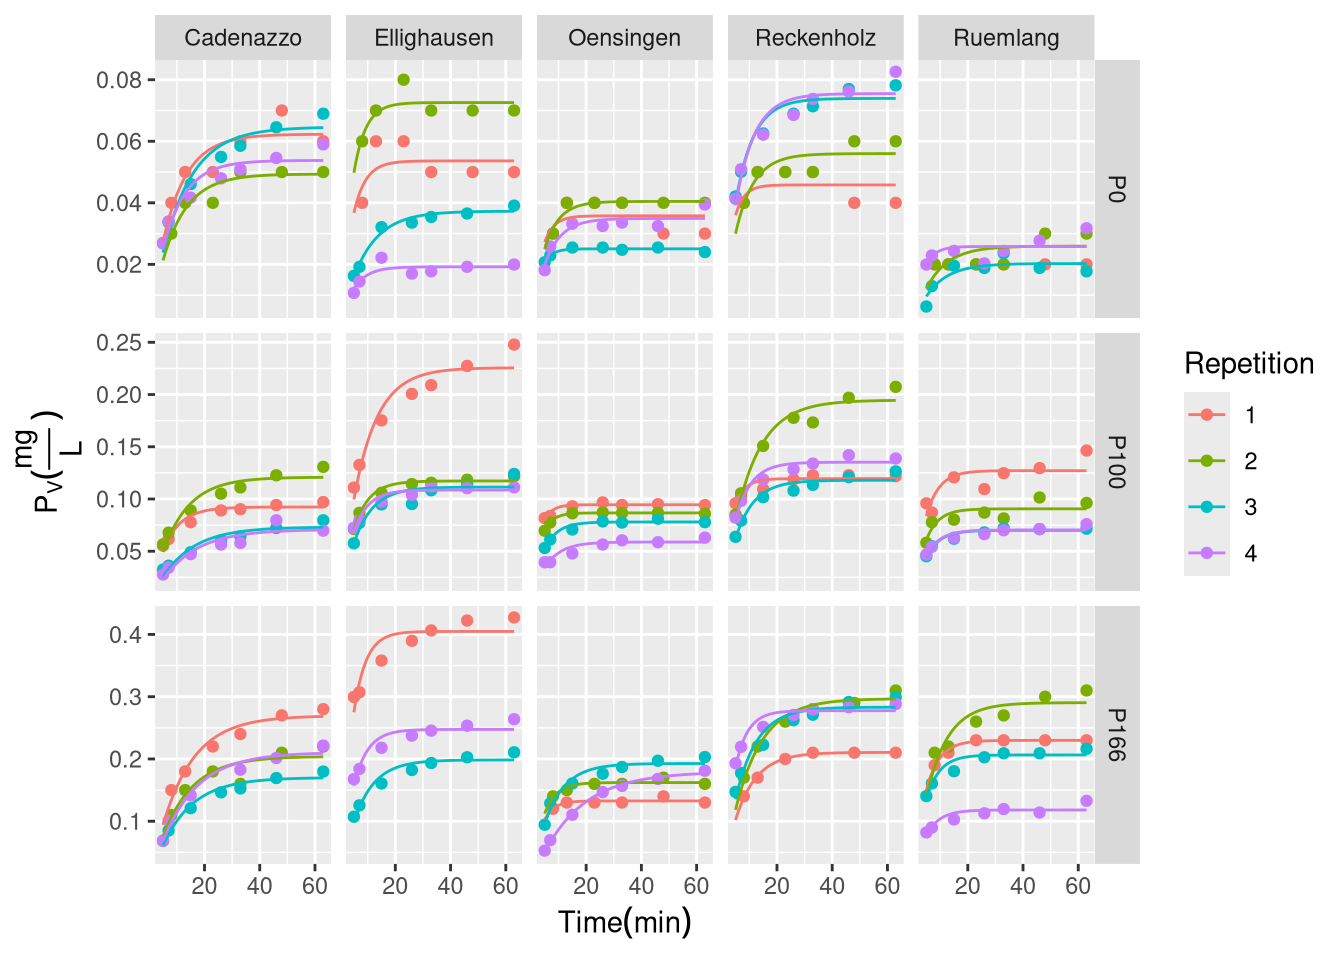

In [ ]:

Res <- nlsList(Pv.mg.L. ~ PS * (1 - exp(-k * (t.dt))) | uid, d[, c("Pv.mg.L.", "uid", "t.dt")],  start=list(PS=0.1,k=0.2))


*(Placeholder for the non-linear model plot)*

This approach proved to be far more successful (Figure X.2). The non-linear model was able to accurately capture the curvilinear shape of the desorption data for nearly all samples. The successful convergence of the models for each unique sample (`uid`) provided robust, sample-specific estimates for both the desorbable P pool ($P_{desorb}$) and the rate constant ($k$). For example, for the sample `Cadenazzo_P166_1`, the model estimated a $P_{desorb}$ of 0.27 mg/L and a $k$ of 0.086 min⁻¹, both with high statistical significance (p \< 0.01).

To account for the hierarchical data structure and obtain the most reliable estimates, the final parameters were extracted from a non-linear mixed-effects model (`nlme`), which models the overall fixed effects for $k$ and $P_{desorb}$ while allowing for random variation among individual samples. These final `nlme`-derived coefficients were used for all subsequent analyses.

## Research Questions:

### How well can current GRUD measurements of $C_P$ predict the relative Yield, P-Uptake and P-Balance?

-   Hypothesis I: The measurements of the equlibrium concentrations of Phosphorus in a solvent do not display significant effects on relative Yield and consequently P-Uptake, since it is strongly dependent on yield. $C_P$ relates strongly to the amount of Phosphorus applied, the P-balance might well be siginificantly correlated to $C_P$ but not explain a lot of variance.

(`geom_point()`).

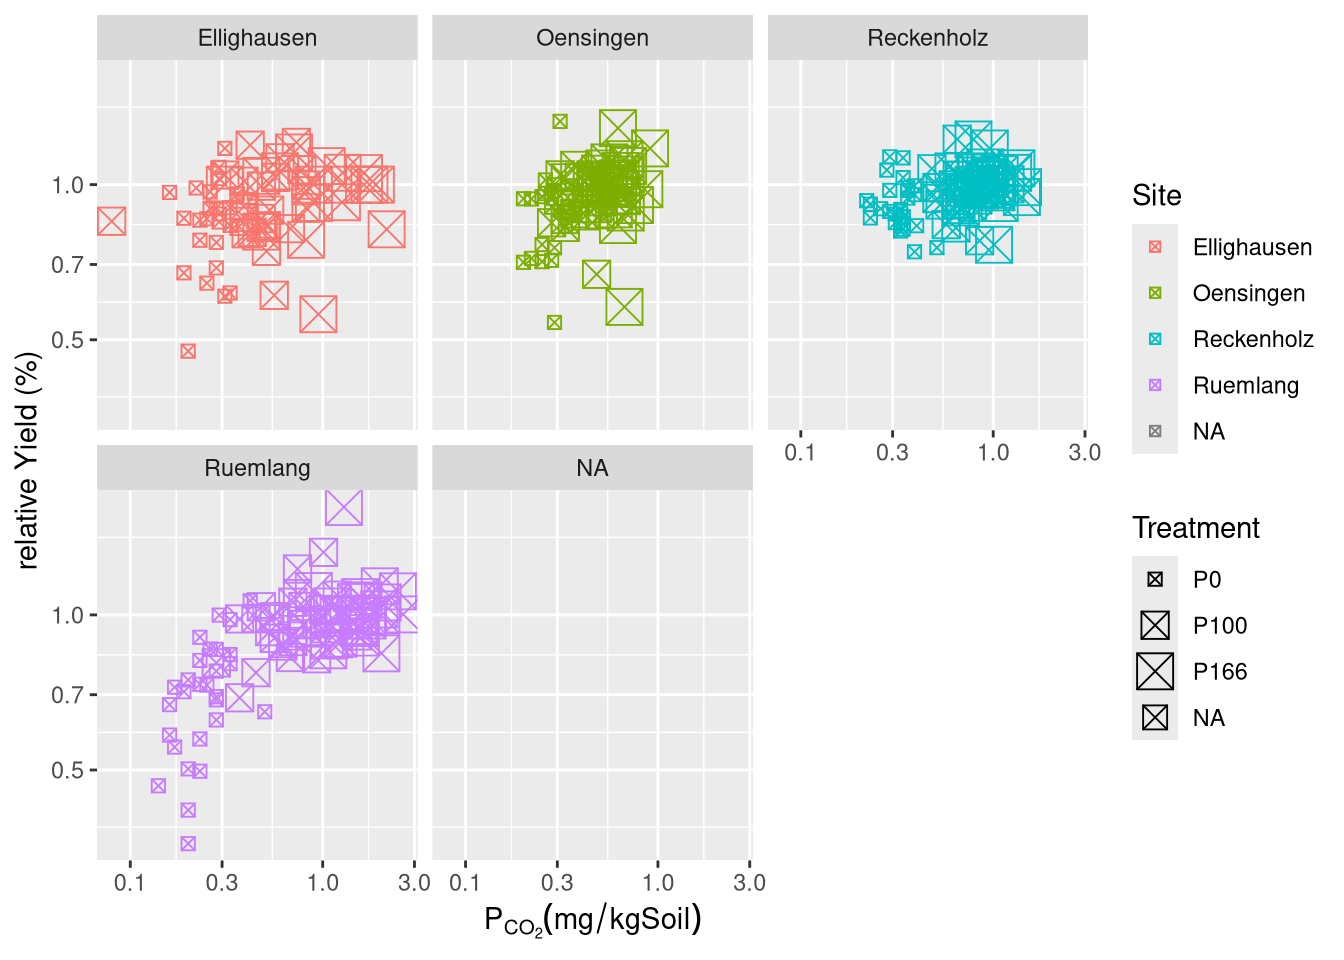

Removed 117 rows containing missing values or values outside the scale range
(`geom_point()`).

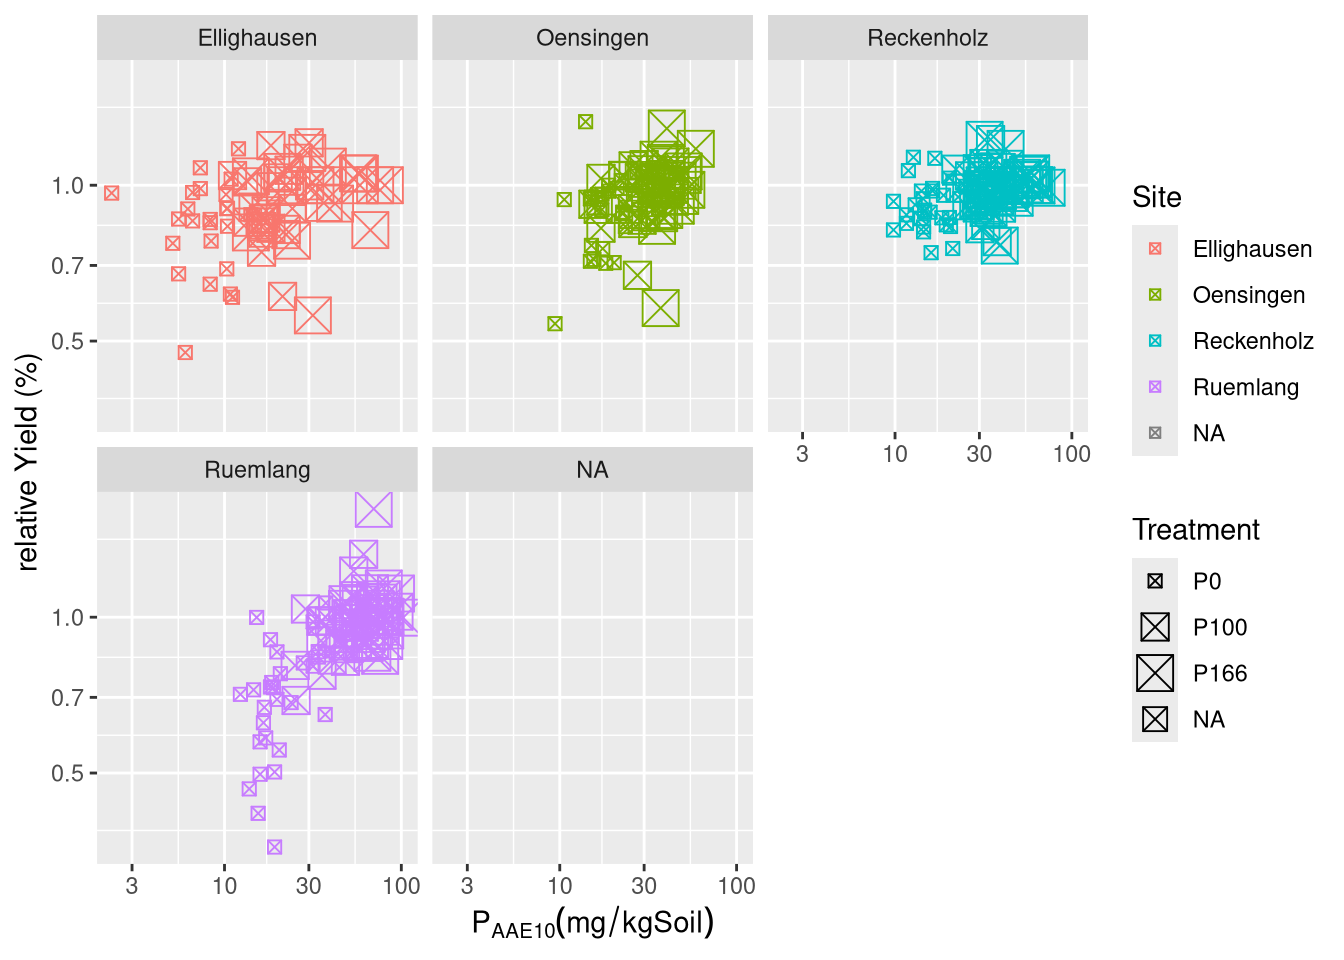

(`geom_point()`).

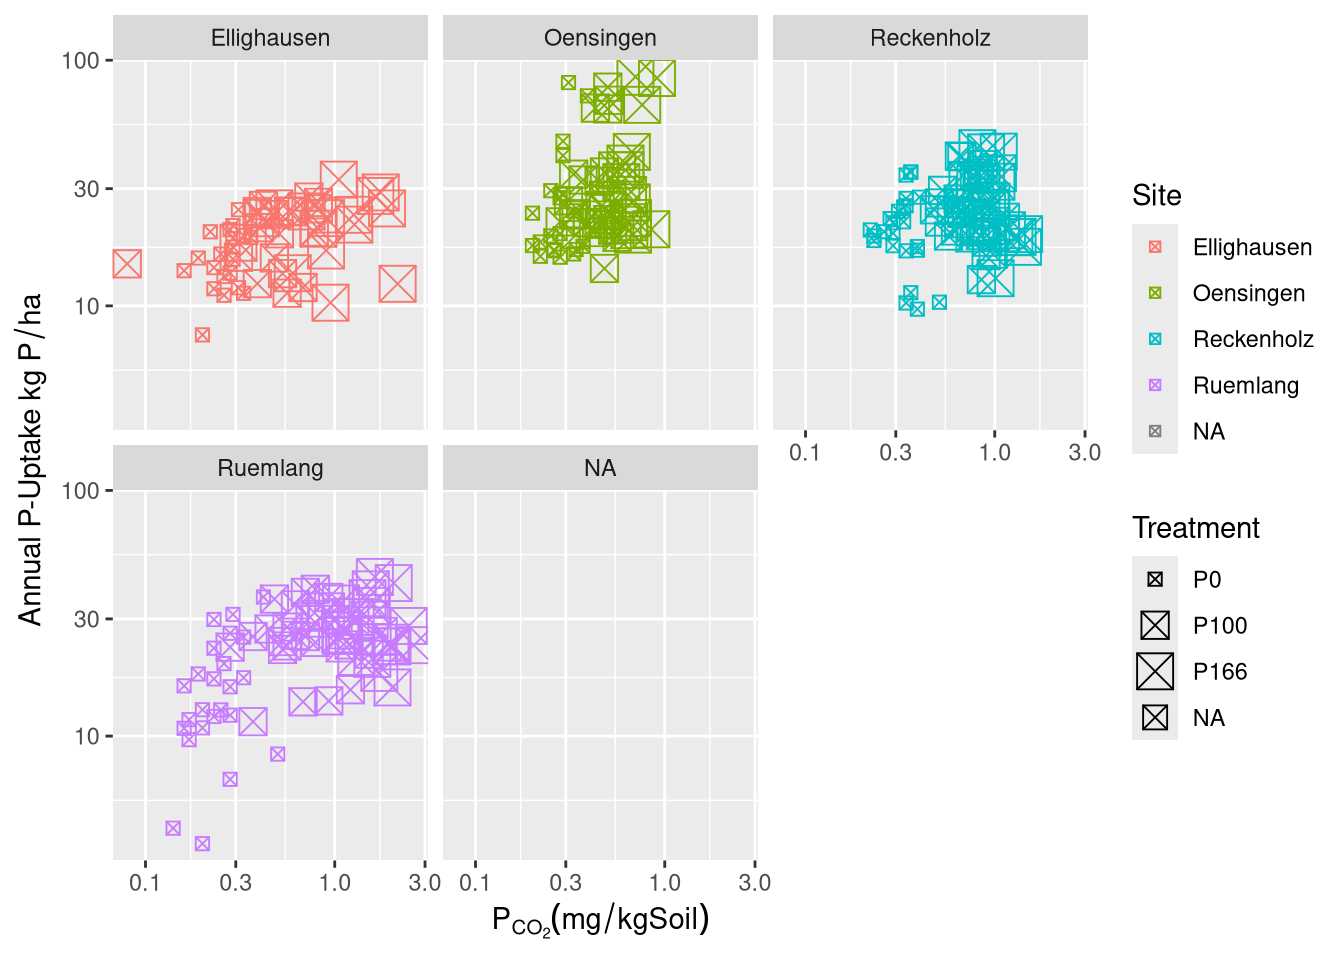

Removed 164 rows containing missing values or values outside the scale range
(`geom_point()`).

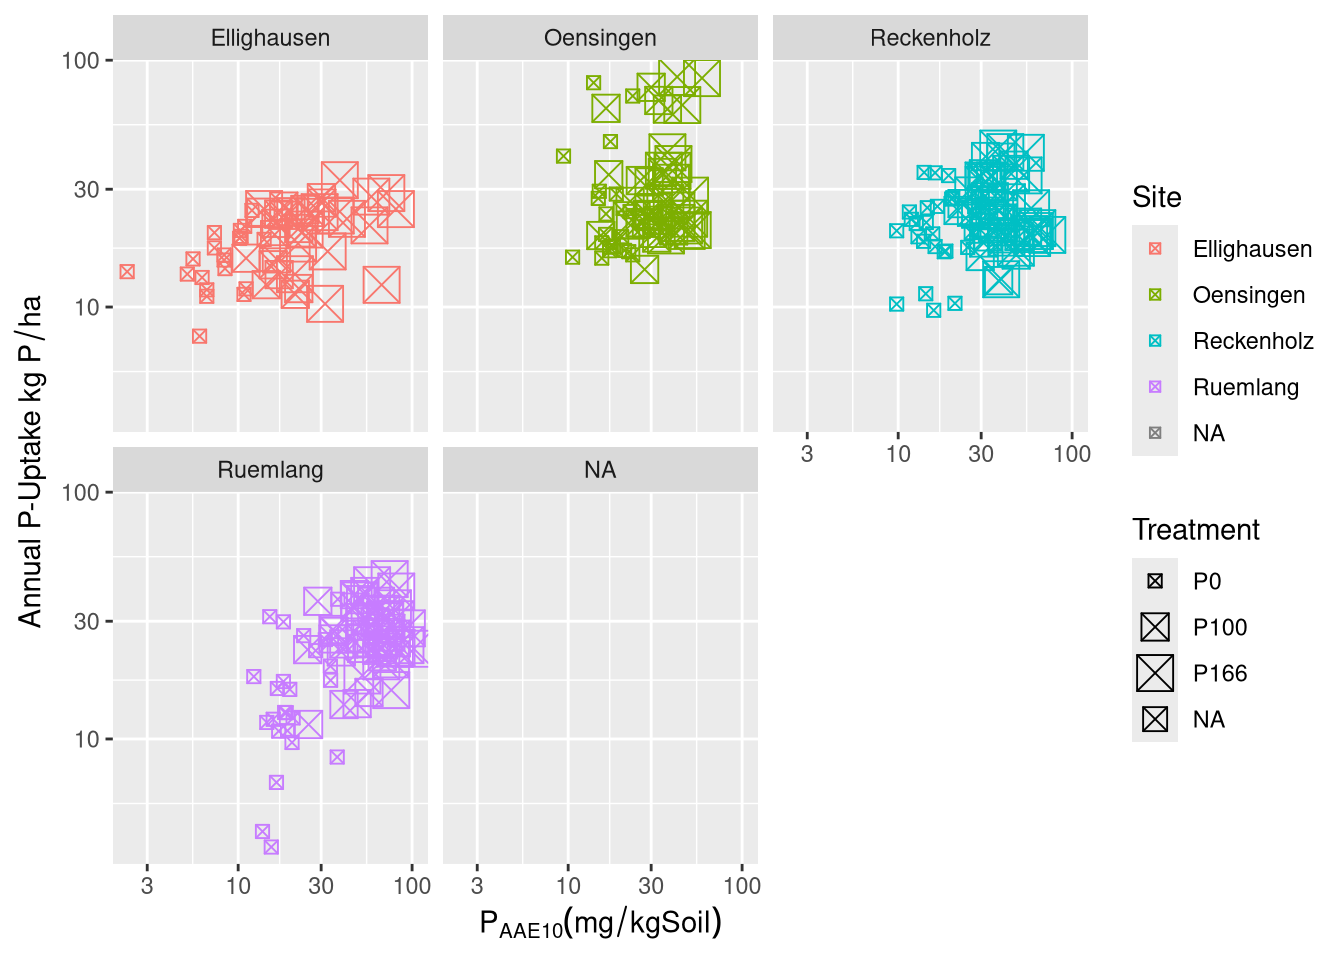

Warning in transformation$transform(x): NaNs produced

Warning in scale_y_log10(): log-10 transformation introduced infinite values.

(`geom_point()`).

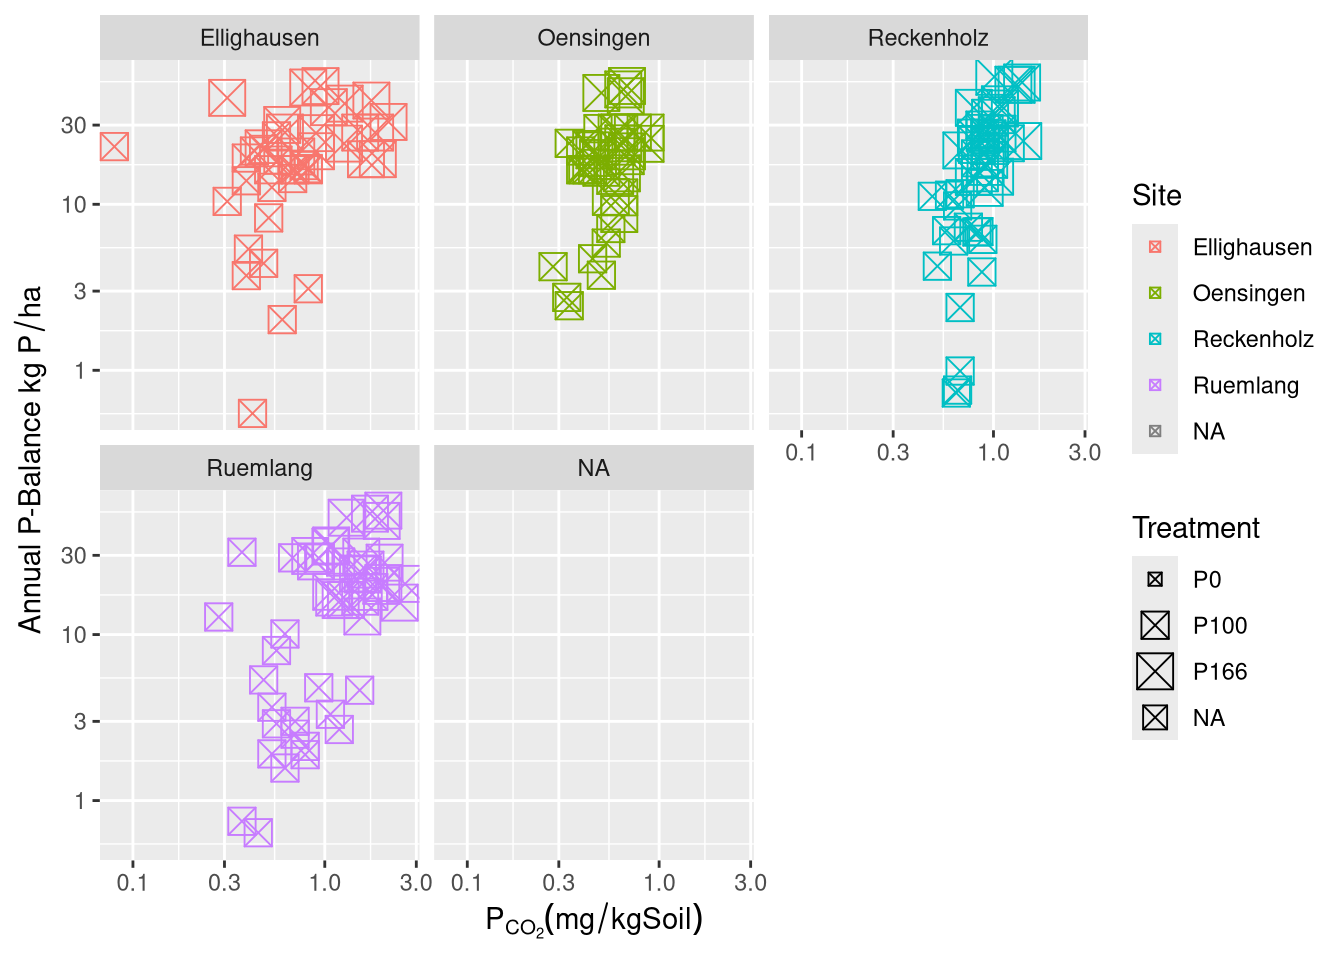

Warning in transformation$transform(x): NaNs produced

Warning in scale_y_log10(): log-10 transformation introduced infinite values.

(`geom_point()`).

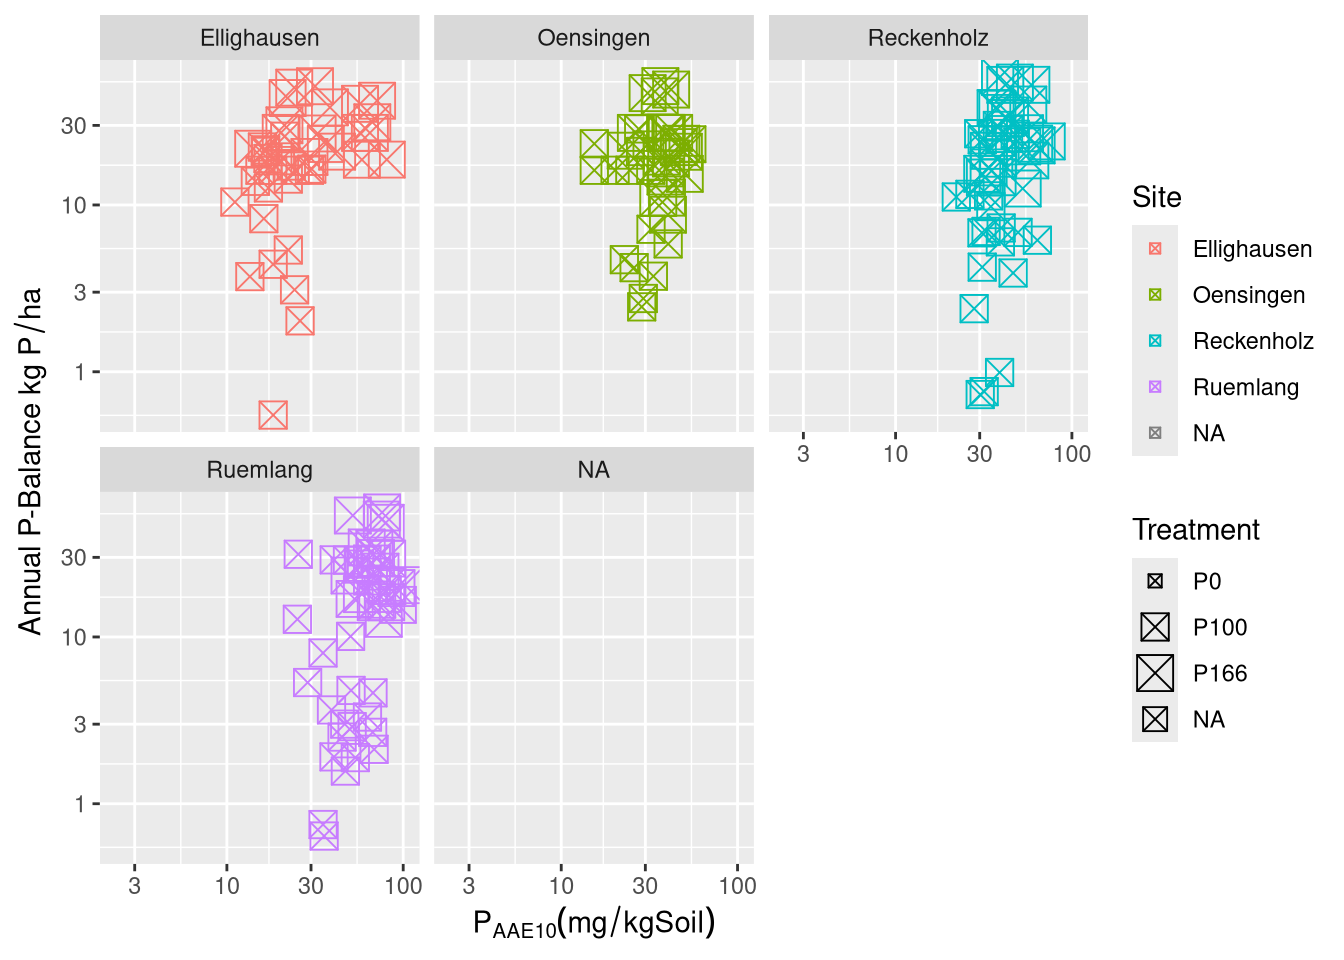

In [ ]:

ggplot(D[D$soil_0_20_P_CO2!=0,],aes(y=Ymain_norm, x=soil_0_20_P_CO2, col=Site, size = Treatment)) +
  geom_point(shape = 7) + 
  scale_x_log10() + scale_y_log10() +
  labs(x=TeX("$P_{CO_{2}}(mg/kg Soil)$"),
         y="relative Yield (%)") +
  facet_wrap( ~ Site, nrow = 2)


Now we want to check the strength of the models in terms of $R^2$ and the significance of the effects in terms of p-values:

In [ ]:

#tab_model(fit.grud.Yrel,fit.grud.Puptake,fit.grud.Pbalance)
report(fit.grud.Yrel)


Loading required namespace: lmerTest

Formula contains log- or sqrt-terms.
  See help("standardize") for how such terms are standardized.
Formula contains log- or sqrt-terms.
  See help("standardize") for how such terms are standardized.

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict Ymain_rel with soil_0_20_P_CO2 and soil_0_20_P_AAE10 (formula:
Ymain_rel ~ log(soil_0_20_P_CO2) * log(soil_0_20_P_AAE10)). The model included
year as random effects (formula: list(~1 | year, ~1 | Site, ~1 | Site:block, ~1
| Site:Treatment)). The model's total explanatory power is substantial
(conditional R2 = 0.58) and the part related to the fixed effects alone
(marginal R2) is of 0.10. The model's intercept, corresponding to
soil_0_20_P_CO2 = 0 and soil_0_20_P_AAE10 = 0, is at 86.80 (95% CI [46.53,
127.06], t(203) = 4.25, p < .001). Within this model:

  - The effect of soil 0 20 P CO2 [log] is statistically non-significant and
positive (beta = 17.43, 95% CI [-6.12, 40.98], t(203) = 1.46, p = 0.146; Std.
beta = 0.84, 95% CI [-0.41, 2.09])
  - The effect of soil 0 20 P AAE10 [log] is statistically non-significant and
positive (beta = 4.59, 95% CI [-5.38, 14.56], t(203) = 0.91, p = 0.365; Std.
beta

Formula contains log- or sqrt-terms.
  See help("standardize") for how such terms are standardized.

boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

Formula contains log- or sqrt-terms.
  See help("standardize") for how such terms are standardized.
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict annual_P_uptake with soil_0_20_P_CO2 and soil_0_20_P_AAE10 (formula:
annual_P_uptake ~ log(soil_0_20_P_CO2) * log(soil_0_20_P_AAE10)). The model
included year as random effects (formula: list(~1 | year, ~1 | Site, ~1 |
Site:block, ~1 | Site:Treatment)). The model's explanatory power related to the
fixed effects alone (marginal R2) is 0.18. The model's intercept, corresponding
to soil_0_20_P_CO2 = 0 and soil_0_20_P_AAE10 = 0, is at 30.63 (95% CI [8.29,
52.97], t(250) = 2.70, p = 0.007). Within this model:

  - The effect of soil 0 20 P CO2 [log] is statistically non-significant and
positive (beta = 9.82, 95% CI [-1.68, 21.32], t(250) = 1.68, p = 0.094; Std.
beta = 1.15, 95% CI [0.16, 2.15])
  - The effect of soil 0 20 P AAE10 [log] is statistically non-significant and
negative (beta = -0.81, 95% CI [-6.14, 4.52], t(250) = -0.30, p = 0.765; Std.
beta = 0.59, 95% CI [-0.06, 1.25])
  - The effect of so

Formula contains log- or sqrt-terms.
  See help("standardize") for how such terms are standardized.
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

Formula contains log- or sqrt-terms.
  See help("standardize") for how such terms are standardized.
boundary (singular) fit: see help('isSingular')

Random effect variances not available. Returned R2 does not account for random effects.

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict annual_P_balance with soil_0_20_P_CO2 and soil_0_20_P_AAE10
(formula: annual_P_balance ~ log(soil_0_20_P_CO2) * log(soil_0_20_P_AAE10)).
The model included year as random effects (formula: list(~1 | year, ~1 | Site,
~1 | Site:block, ~1 | Site:Treatment)). The model's explanatory power related
to the fixed effects alone (marginal R2) is 0.08. The model's intercept,
corresponding to soil_0_20_P_CO2 = 0 and soil_0_20_P_AAE10 = 0, is at -5.50
(95% CI [-36.39, 25.39], t(265) = -0.35, p = 0.726). Within this model:

  - The effect of soil 0 20 P CO2 [log] is statistically non-significant and
negative (beta = -10.40, 95% CI [-27.13, 6.33], t(265) = -1.22, p = 0.222; Std.
beta = -0.44, 95% CI [-1.26, 0.38])
  - The effect of soil 0 20 P AAE10 [log] is statistically non-significant and
positive (beta = 1.98, 95% CI [-5.24, 9.21], t(265) = 0.54, p = 0.590; Std.
beta = -0.26, 95% CI [-0.87, 0.35])
  - The eff

here I also show the non linear mixed models, following the Mitscherlich saturation curve:

In [ ]:

library(nlme)

# Make sure grouping variables are factors
D$year  <- as.factor(D$year)
D$Site  <- as.factor(D$Site)
D$block <- as.factor(D$block)
D$crop <- as.factor(D$crop)
# Fit the model
# fit.mitscherlich.CO2.Yrel <- nlme(
#   Ymain_rel ~ A * (1 - exp(-k * soil_0_20_P_CO2 + E)),                
#   fixed = A + k + E ~ soil_0_20_clay + soil_0_20_pH_H2O + ansum_sun + ansum_prec,
#   random = A ~ 1 | year/Site/block,
#   data = D,
#   subset = Treatment != "P166",
#   start = c(
#     A = 1100, A1 = 0, A2 = 0, A3 = 0, A4 = 0,
#     k = 0.05, k1 = 0, k2 = 0, k3 = 0, k4 = 0,
#     E = -3, E1 = 0, E2 = 0, E3 = 0, E4 = 0
#   ),
#   control = nlmeControl(maxIter = 500),
#   na.action = na.omit
# )

summary(fit.mitscherlich.CO2.Yrel)
anova(fit.mitscherlich.CO2.Yrel)

model_performance(fit.mitscherlich.CO2.Yrel)

r.square.CO2 <- 1-sum(residuals(fit.mitscherlich.CO2.Yrel)^2)/sum((D$Ymain_rel-mean(D$Ymain_rel,na.rm=TRUE))^2,na.rm = TRUE)

# Fit the model
fit.mitscherlich.CO2.Yrel <- nlme(
  Ymain_rel ~ A * (1 - exp(-k * kPS + E)),                
  fixed = A + k + E ~ soil_0_20_clay + soil_0_20_pH_H2O + ansum_sun + ansum_prec,
  random = A ~ 1 | year/Site/block,
  data = D,
  subset = Treatment != "P166",
  start = c(
    A = 600, A1 = 0, A2 = 0, A3 = 0, A4 = 0,
    k = 3, k1 = 0, k2 = 0, k3 = 0, k4 = 0,
    E = -3, E1 = 0, E2 = 0, E3 = 0, E4 = 0
  ),
  control = nlmeControl(maxIter = 1500),
  na.action = na.omit
)

summary(fit.mitscherlich.CO2.Yrel)
anova(fit.mitscherlich.CO2.Yrel)

model_performance(fit.mitscherlich.CO2.Yrel)

r.square.CO2 <- 1-sum(residuals(fit.mitscherlich.CO2.Yrel)^2)/sum((D$Ymain_rel-mean(D$Ymain_rel,na.rm=TRUE))^2,na.rm = TRUE)



# fit.mitscherlich.CO2.Ynorm <- nlme(
#   Ymain_norm ~ A * (1 - exp(-k * kPS + E)),                
#   fixed = A + k + E ~ soil_0_20_clay + soil_0_20_pH_H2O + ansum_sun + ansum_prec,
#   random = A ~ 1 | year/Site/block,
#   data = D,
#   subset = Treatment != "P166",
#   start = c(
#     A = 6, A1 = 0, A2 = 0, A3 = 0, A4 = 0,
#     k = 3, k1 = 0, k2 = 0, k3 = 0, k4 = 0,
#     E = -3, E1 = 0, E2 = 0, E3 = 0, E4 = 0
#   ),
#   control = nlmeControl(maxIter = 1500),
#   na.action = na.omit
# )

summary(fit.mitscherlich.CO2.Yrel)
anova(fit.mitscherlich.CO2.Yrel)

model_performance(fit.mitscherlich.CO2.Yrel)

r.square.CO2 <- 1-sum(residuals(fit.mitscherlich.CO2.Yrel)^2)/sum((D$Ymain_rel-mean(D$Ymain_rel,na.rm=TRUE))^2,na.rm = TRUE)

# Fit the model
fit.mitscherlich.CO2.Yrel <- nlme(
  Ymain_norm ~ A * (1 - exp(-k * soil_0_20_P_CO2 + E)),                
  fixed = A + k + E ~ soil_0_20_clay + soil_0_20_pH_H2O + ansum_sun + ansum_prec,
  random = A ~ 1 | year/Site/block,
  data = D,
  subset = Treatment != "P166",
  start = c(
    A = 1100, A1 = 0, A2 = 0, A3 = 0, A4 = 0,
    k = 0.05, k1 = 0, k2 = 0, k3 = 0, k4 = 0,
    E = -3, E1 = 0, E2 = 0, E3 = 0, E4 = 0
  ),
  control = nlmeControl(maxIter = 500),
  na.action = na.omit
)

summary(fit.mitscherlich.CO2.Yrel)
anova(fit.mitscherlich.CO2.Yrel)

model_performance(fit.mitscherlich.CO2.Yrel)

r.square.CO2 <- 1-sum(residuals(fit.mitscherlich.CO2.Yrel)^2)/sum((D$Ymain_rel-mean(D$Ymain_rel,na.rm=TRUE))^2,na.rm = TRUE)


With the covariate and random effect used as by Juliane Hirte we obtain , I don’t know how to interpret that, I fear that the model is overfitting data.

### How do GRUD-measurements of $C_P$ relate to the soil properties $C_\text{org}$-content, clay-content, silt-content and pH?

-   Hypothesis II: Given the known capacity of clay and silt compounds to adsorb orthophosphate a positive correlation between $C_P$ (for both $CO_2$ and AAE10) and silt- and clay-content. $C_\text{org}$ has been reported to positively influence the capacity of Phosphorus as well, it is plausible it also shows a positive correlation with $C_P$. AAE10 also deploys $Na_4EDTA$ which is easily captured by $Mg^{2+}$ and $Ca^{2+}$, therefore it is officially by GRUD advised against being used in soils with $\text{pH}>6.8$, therefore $C_P$-AAE10 will presumably be negatively correlated to pH.

In [ ]:


anova(fit.soil.CO2)


Type III Analysis of Variance Table with Satterthwaite's method
                   Sum Sq  Mean Sq NumDF  DenDF F value Pr(>F)
soil_0_20_clay   0.017260 0.017260     1 38.410  0.1191 0.7319
soil_0_20_pH_H2O 0.080631 0.080631     1 38.254  0.5562 0.4604
soil_0_20_Corg   0.029198 0.029198     1 38.466  0.2014 0.6561
soil_0_20_silt   0.005041 0.005041     1 40.886  0.0348 0.8530
Feox             0.102556 0.102556     1 14.728  0.7074 0.4138
Alox             0.001448 0.001448     1  4.877  0.0100 0.9244

           R2m       R2c
[1,] 0.1028618 0.6635412

Type III Analysis of Variance Table with Satterthwaite's method
                   Sum Sq  Mean Sq NumDF  DenDF F value Pr(>F)
soil_0_20_clay   0.000000 0.000000     1 34.138  0.0000 0.9993
soil_0_20_pH_H2O 0.022655 0.022655     1 30.975  0.3822 0.5409
soil_0_20_Corg   0.091344 0.091344     1 27.873  1.5412 0.2248
soil_0_20_silt   0.033276 0.033276     1 34.322  0.5614 0.4588
Feox             0.023984 0.023984     1  7.835  0.4047 0.5428
Alox             0.104053 0.104053     1  3.886  1.7556 0.2577

           R2m       R2c
[1,] 0.2849305 0.8808985

### Can the Inclusion of the net-release-kinetic of Orthophosphate improve the model power of predicting relative Yield, P-Uptake and P-Balance?

-   Hypothesis III: Given the comparably low solubility of $PO_4^{3-}$ in the water-soil interface, most P is transported to the rhizosphere via diffusion. As a consequence the intensity of $PO_4^{3-}$ might not adequately account for the P-uptake in the harvested plant. Since the diffusion process is in its velocity a kinetic and in its finally reached intensity a thermodynamic process, the inclusion of kinetic parameters might well improve the performance.

In [ ]:

fit.mitscherlich.PS.Yrel <- nlme(
  Ymain_rel ~ A * (1 - exp(-r * PS + E)),                
  fixed = A + r + E ~ k + soil_0_20_clay + soil_0_20_pH_H2O + ansum_sun + ansum_prec,
  random = A ~ 1 | year/Site/block,
  data = D,
  start = c(
    A = 220, A1 = 0, A2 = 0, A3 = 0, A4 = 0, A5 = 0,
    r = 1, r1 = 0, r2 = 0, r3 = 0, r4 = 0, r5 = 0,
    E = -1, E1 = 0, E2 = 0, E3 = 0, E4 = 0, E5 = 0
  ),
  control = nlmeControl(maxIter = 500),
  na.action = na.omit
)

summary(fit.mitscherlich.PS.Yrel)
anova(fit.mitscherlich.PS.Yrel)

model_performance(fit.mitscherlich.PS.Yrel)

r.square.PS <- 1-sum(residuals(fit.mitscherlich.PS.Yrel)^2)/sum((D$Ymain_rel-mean(D$Ymain_rel,na.rm=TRUE))^2,na.rm = TRUE)

fit.mitscherlich.kPS.Yrel <- nlme(
  Ymain_rel ~ A * (1 - exp(-k * PS + E)),                
  fixed = A + E ~ soil_0_20_clay + soil_0_20_pH_H2O + ansum_sun + ansum_prec,
  random = A ~ 1 | year/Site/block,
  data = D,
  start = c(
    A = 220, A1 = 0, A2 = 0, A3 = 0, A4 = 0,
    E = -1, E1 = 0, E2 = 0, E3 = 0, E4 = 0
  ),
  control = nlmeControl(maxIter = 500),
  na.action = na.omit
)

summary(fit.mitscherlich.kPS.Yrel)
anova(fit.mitscherlich.kPS.Yrel)

model_performance(fit.mitscherlich.kPS.Yrel)

r.square.kPS <- 1-sum(residuals(fit.mitscherlich.kPS.Yrel)^2)/sum((D$Ymain_rel-mean(D$Ymain_rel,na.rm=TRUE))^2,na.rm = TRUE)


With the covariate and random effect used as by Juliane Hirte we obtain I don’t know how to interpret that, I fear that the model is overfitting data, the same might be true for the model that used $k\times PS$ as a predictor with .

I also tried more conservative models, where I log-transformed the concentrations and PS, also I was more cautious with random effects. This resulted in coefficients that were not as straight-forward as the mitscherlich coefficients to interpret.

In [ ]:

# relative Yield
anova(fit.kin.Yrel)


Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF  DenDF F value  Pr(>F)  
k         963.20  963.20     1 249.06  3.1391 0.07766 .
log(PS)    49.89   49.89     1 244.16  0.1626 0.68712  
k:log(PS) 997.62  997.62     1 241.96  3.2513 0.07261 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Ymain_rel ~ k * log(PS) + (1 | year) + (1 | Site) + (1 | Site:block)
   Data: D

REML criterion at convergence: 2220.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.75169 -0.56241 -0.01436  0.55727  2.90436 

Random effects:
 Groups     Name        Variance Std.Dev.
 Site:block (Intercept)   0.00    0.000  
 year       (Intercept) 780.33   27.934  
 Site       (Intercept)  10.88    3.299  
 Residual               306.84   17.517  
Number of obs: 259, groups:  Site:block, 16; year, 6; Site, 4

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  105.335     16.782  22.392   6.277 2.37e-06 ***
k            117.175     66.135 249.063   1.772   0.0777 .  
log(PS)       -2.166      5.370 244.163  -0.403   0.6871    
k:log(PS)     50.701     28.119 241.960   1.803   0.0726 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' '

            R2m     R2c
[1,] 0.03367883 0.72997

Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF  DenDF F value Pr(>F)
k         72.729  72.729     1 294.70  0.9450 0.3318
log(PS)   59.809  59.809     1 295.38  0.7771 0.3787
k:log(PS) 65.608  65.608     1 295.56  0.8525 0.3566

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: annual_P_uptake ~ k * log(PS) + (1 | year) + (1 | Site) + (1 |  
    Site:block)
   Data: D

REML criterion at convergence: 2212

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2548 -0.4387 -0.0522  0.3493  4.7590 

Random effects:
 Groups     Name        Variance Std.Dev.
 Site:block (Intercept)   0.00    0.000  
 year       (Intercept) 113.12   10.636  
 Site       (Intercept)  16.65    4.080  
 Residual                76.96    8.773  
Number of obs: 306, groups:  Site:block, 16; year, 7; Site, 4

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   31.648      7.243  49.425   4.370 6.38e-05 ***
k             29.822     30.678 294.705   0.972    0.332    
log(PS)        2.206      2.502 295.378   0.882    0.379    
k:log(PS)     12.111     13.117 295.564   0.923    0.357    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' '

            R2m       R2c
[1,] 0.05991825 0.6500246

Type III Analysis of Variance Table with Satterthwaite's method
          Sum Sq Mean Sq NumDF  DenDF F value   Pr(>F)    
k          457.3   457.3     1 278.74  2.7599  0.09778 .  
log(PS)   3223.1  3223.1     1 286.56 19.4534 1.46e-05 ***
k:log(PS)  416.1   416.1     1 282.68  2.5116  0.11413    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: annual_P_balance ~ k * log(PS) + (1 | year) + (1 | Site) + (1 |  
    Site:block)
   Data: D

REML criterion at convergence: 2571.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1772 -0.6269  0.0013  0.6561  2.5600 

Random effects:
 Groups     Name        Variance Std.Dev.
 Site:block (Intercept)  25.76    5.075  
 year       (Intercept)  56.96    7.547  
 Site       (Intercept)  26.24    5.122  
 Residual               165.69   12.872  
Number of obs: 321, groups:  Site:block, 16; year, 7; Site, 4

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   46.247     10.093 157.535   4.582 9.32e-06 ***
k             83.864     50.481 278.742   1.661   0.0978 .  
log(PS)       18.149      4.115 286.557   4.411 1.46e-05 ***
k:log(PS)     34.369     21.686 282.680   1.585   0.1141    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 

           R2m       R2c
[1,] 0.5881569 0.7515403

### Are the kinetic coefficients $k$ and $PS$($k$ can be interpreted as the relative speed of desorption, $PS$ is the equilibrium concentration of $PO_4^{3-}$ of the observed desorption in the dried fine earth-water suspension 1:20 by weight) related to soil properties?

-   Hypothesis IV: Clay particles as well as organic compounds with negative surface charges provide surfaces for P-sorption, especially their structure, but in general their respective concentration in a soil can be expected to significantly influence the kinetic and thermodynamic of the P-desorption reaction. The $pH$ dictates the form of orthophosphate, with $pH<6.5$, the predominant form will be $H_2PO_4^-$, this should reduce electrical interactions and increase the movement- and therefore diffusion-speed.

In [ ]:

anova(fit.soil.PS)


Type III Analysis of Variance Table with Satterthwaite's method
                   Sum Sq  Mean Sq NumDF  DenDF F value  Pr(>F)  
soil_0_20_clay   0.002083 0.002083     1 38.033  0.0569 0.81272  
soil_0_20_pH_H2O 0.000134 0.000134     1 37.384  0.0037 0.95203  
soil_0_20_Corg   0.161222 0.161222     1 31.905  4.4045 0.04385 *
soil_0_20_silt   0.004846 0.004846     1 38.673  0.1324 0.71793  
Feox             0.001149 0.001149     1  0.347  0.0314 0.91632  
Alox             0.012358 0.012358     1  0.257  0.3376 0.79220  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Warning in RET$pfunction("adjusted", ...): Completion with error > abseps
Warning in RET$pfunction("adjusted", ...): Completion with error > abseps


     Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = log(PS) ~ soil_0_20_clay + soil_0_20_pH_H2O + 
    soil_0_20_Corg + soil_0_20_silt + Feox + Alox + (1 | year) + 
    (1 | Site) + (1 | Site:block) + (1 | Site:Treatment), data = D)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)
(Intercept) == 0      -4.315984   2.026178  -2.130    0.178
soil_0_20_clay == 0   -0.007322   0.030690  -0.239    1.000
soil_0_20_pH_H2O == 0 -0.007820   0.129130  -0.061    1.000
soil_0_20_Corg == 0    0.635270   0.302698   2.099    0.190
soil_0_20_silt == 0   -0.010244   0.028153  -0.364    0.999
Feox == 0             -0.052865   0.298418  -0.177    1.000
Alox == 0              0.603465   1.038573   0.581    0.989
(Adjusted p values reported -- single-step method)

Type III Analysis of Variance Table with Satterthwaite's method
                    Sum Sq   Mean Sq NumDF  DenDF F value   Pr(>F)   
soil_0_20_clay   0.0118462 0.0118462     1 39.973 10.7210 0.002191 **
soil_0_20_pH_H2O 0.0011812 0.0011812     1 38.291  1.0690 0.307665   
soil_0_20_Corg   0.0090425 0.0090425     1 35.487  8.1836 0.007040 **
soil_0_20_silt   0.0012705 0.0012705     1 10.804  1.1498 0.306956   
Feox             0.0000004 0.0000004     1  0.968  0.0003 0.988186   
Alox             0.0004765 0.0004765     1  1.117  0.4312 0.620552   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Warning in RET$pfunction("adjusted", ...): Completion with error > abseps


     Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = k ~ soil_0_20_clay + soil_0_20_pH_H2O + soil_0_20_Corg + 
    soil_0_20_silt + Feox + Alox + (1 | year) + (1 | Site) + 
    (1 | Site:block) + (1 | Site:Treatment), data = D)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)   
(Intercept) == 0       0.608404   0.351212   1.732  0.37925   
soil_0_20_clay == 0   -0.016659   0.005088  -3.274  0.00675 **
soil_0_20_pH_H2O == 0 -0.022256   0.021526  -1.034  0.84784   
soil_0_20_Corg == 0    0.137353   0.048014   2.861  0.02596 * 
soil_0_20_silt == 0    0.004094   0.003818   1.072  0.82619   
Feox == 0              0.001024   0.054815   0.019  1.00000   
Alox == 0             -0.128860   0.196235  -0.657  0.97803   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)

Type III Analysis of Variance Table with Satterthwaite's method
                  Sum Sq Mean Sq NumDF  DenDF F value   Pr(>F)   
soil_0_20_clay   0.27383 0.27383     1 37.930  3.2642 0.078745 . 
soil_0_20_pH_H2O 0.00989 0.00989     1 37.703  0.1179 0.733211   
soil_0_20_Corg   0.63137 0.63137     1 32.625  7.5263 0.009799 **
soil_0_20_silt   0.00591 0.00591     1 39.206  0.0705 0.791988   
Feox             0.04311 0.04311     1  0.225  0.5139 0.775407   
Alox             0.00881 0.00881     1  0.130  0.1050 0.904677   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Warning in RET$pfunction("adjusted", ...): Completion with error > abseps
Warning in RET$pfunction("adjusted", ...): Completion with error > abseps
Warning in RET$pfunction("adjusted", ...): Completion with error > abseps


     Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = I(log(k * PS)) ~ soil_0_20_clay + soil_0_20_pH_H2O + 
    soil_0_20_Corg + soil_0_20_silt + Feox + Alox + (1 | year) + 
    (1 | Site) + (1 | Site:block) + (1 | Site:Treatment), data = D)

Linear Hypotheses:
                      Estimate Std. Error z value Pr(>|z|)  
(Intercept) == 0      -5.22214    2.67612  -1.951   0.2524  
soil_0_20_clay == 0   -0.08506    0.04708  -1.807   0.3312  
soil_0_20_pH_H2O == 0 -0.06836    0.19908  -0.343   0.9993  
soil_0_20_Corg == 0    1.29047    0.47039   2.743   0.0367 *
soil_0_20_silt == 0   -0.01141    0.04296  -0.266   0.9998  
Feox == 0              0.24813    0.34612   0.717   0.9669  
Alox == 0              0.36766    1.13436   0.324   0.9995  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)

### Is the method presented by Flossmann and Richter (1982) with the double extraction replicable with the soils from the STYCS-trial?

-   Hypothesis V: The authors expect the desorption kinetics to follow a 1. order kinetic, with the relation: $$ \frac{dP}{dt}=PS(1-e^{-kt})$$ where $PS$ is estimated as $PS=[P_\text{Olsen/CAL}]-[P_{H_2O}]$, denoted as the semi-labile P-pool. The Olsen- and CAL-method deploy extractants that increase the solubility by more than order of magnitude. This presents the problem, that the estimation of $PS$ is likely to high. It was chosen by the authors in order to make the equation linearizable, so if the linearization is not well behaved, a non-linear regression might deliver a better estimation of both parameters.

singular.ok = singular.ok, ...): NA/NaN/Inf in 'y'

Warning in summary.lm(el): essentially perfect fit: summary may be unreliable

Call:
  Model: Y1 ~ t.min. | uid 
   Data: d[d$Repetition == 1 | d$Repetition == 2, ] 

Coefficients:
   (Intercept) 
                      Estimate Std. Error    t value     Pr(>|t|)
Cadenazzo_P0_1     -0.12891945 0.01537006  -8.387702 4.332766e-12
Cadenazzo_P0_2     -0.12037045 0.01537006  -7.831491 4.433395e-11
Cadenazzo_P100_1            NA         NA         NA           NA
Cadenazzo_P100_2            NA         NA         NA           NA
Cadenazzo_P166_1   -0.26932199 0.01537006 -17.522512 6.499702e-27
Cadenazzo_P166_2   -0.19243796 0.01537006 -12.520316 2.550625e-19
Ellighausen_P0_1   -0.10464296 0.01537006  -6.808236 3.136905e-09
Ellighausen_P0_2   -0.11438112 0.01537006  -7.441815 2.257472e-10
Ellighausen_P100_1          NA         NA         NA           NA
Ellighausen_P100_2          NA         NA         NA           NA
Ellighausen_P166_1          NA         NA         NA           NA
Oensingen_P0_1     -0.03432646 0.01537006  -2.233333 2.882091e-02
Oensingen_P0_2     -0.05

`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

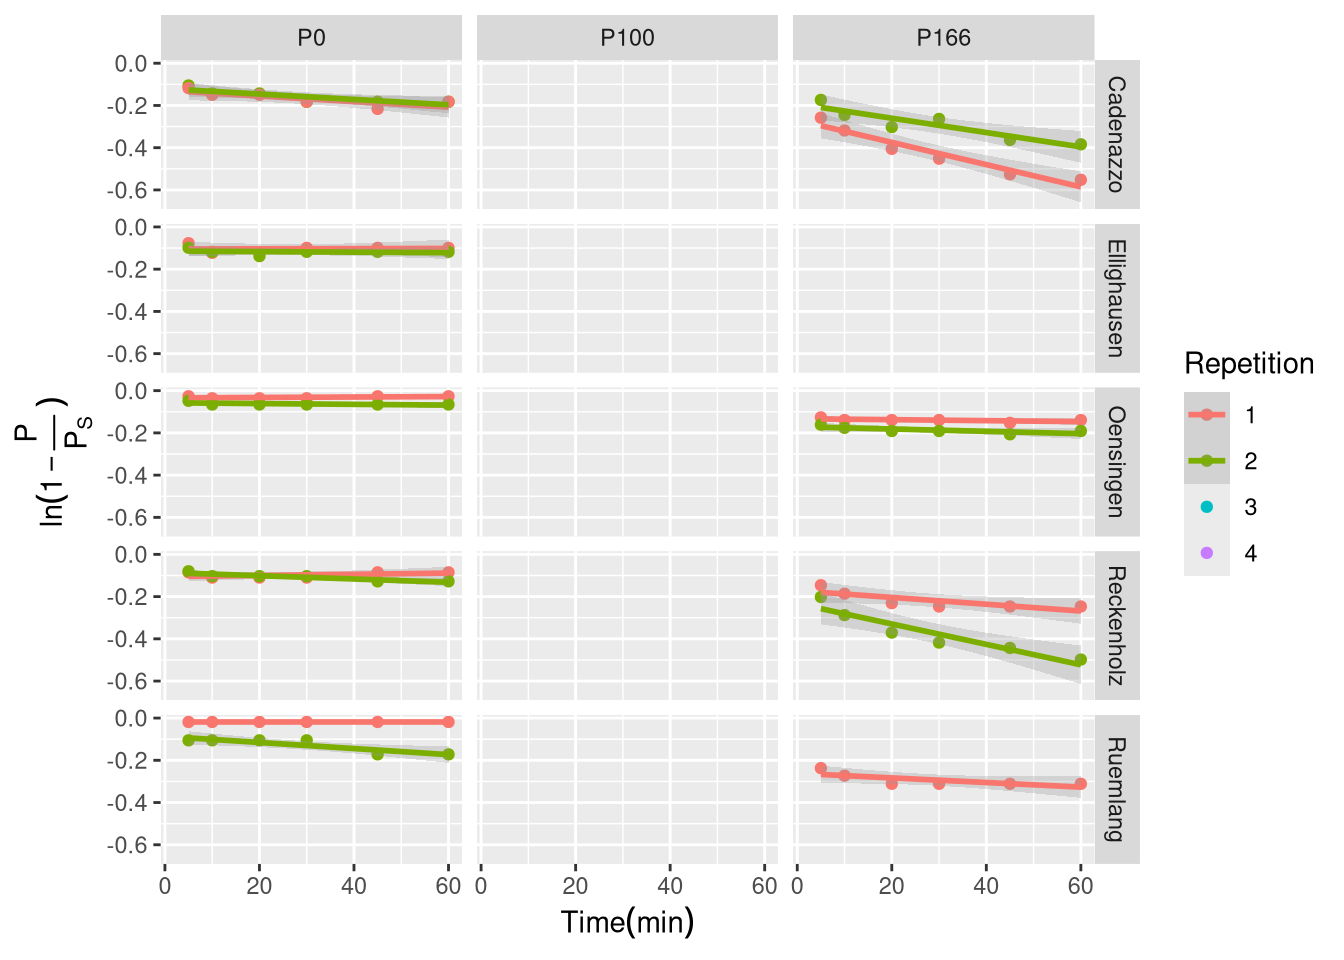

In [ ]:

res <- lmList(Y1 ~ t.min. | uid, d[d$Repetition==1|d$Repetition==2,],na.action = na.pass)


The relation can be improved:

= start): singular gradient

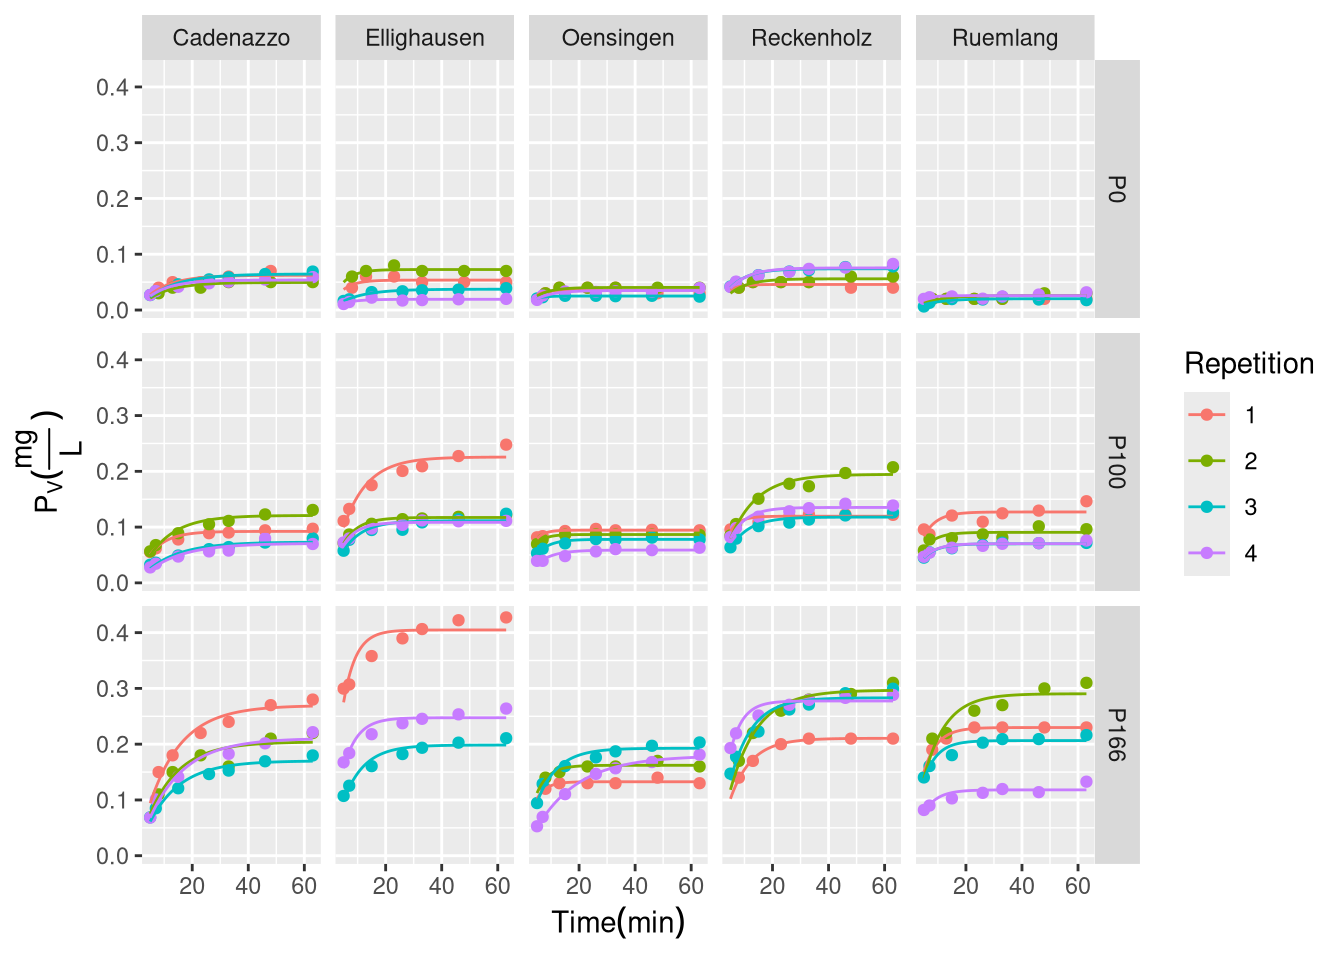

In [ ]:

Res <- nlsList(Pv.mg.L. ~ PS * (1 - exp(-k * (t.dt))) | uid, d[, c("Pv.mg.L.", "uid", "t.dt")],  start=list(PS=0.1,k=0.2))


Now we see how those parameters depend on the tratment:

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded
Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded
Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

= start): singular gradient

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded
Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded
Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Iteration 1, LME step: nlminb() did not converge (code = 1). Do increase
'msMaxIter'!

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded
Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded
Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

Warning in nlme.formula(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)), fixed = PS + :
Singular precision matrix in level -1, block 1

Warning in data.frame(PS = fixef["PS"], k = fixef["k"], ui = lvl, Site =
d.tmp[1, : row names were found from a short variable and have been discarded

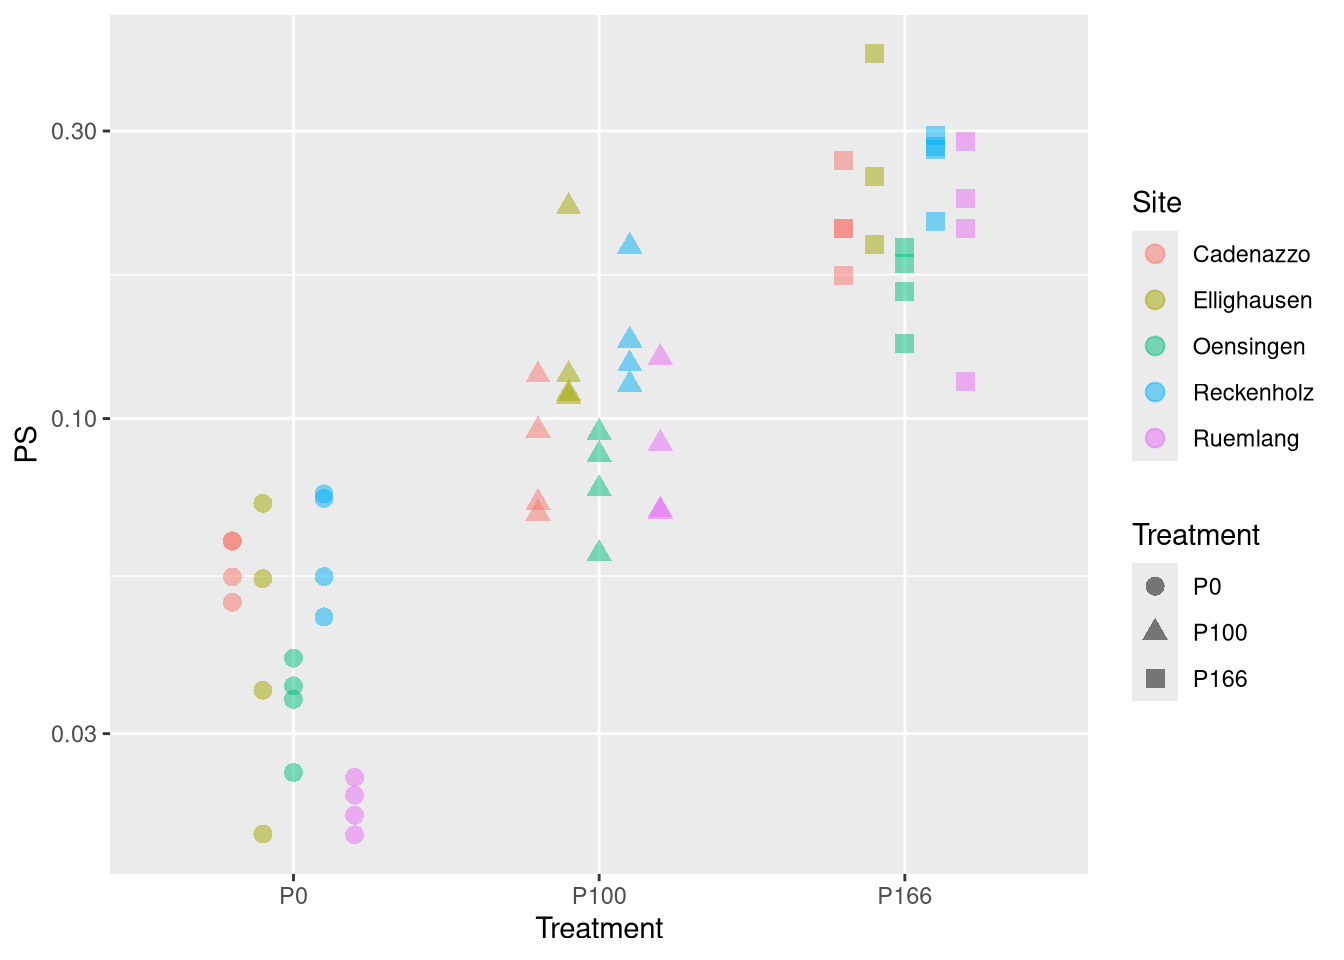

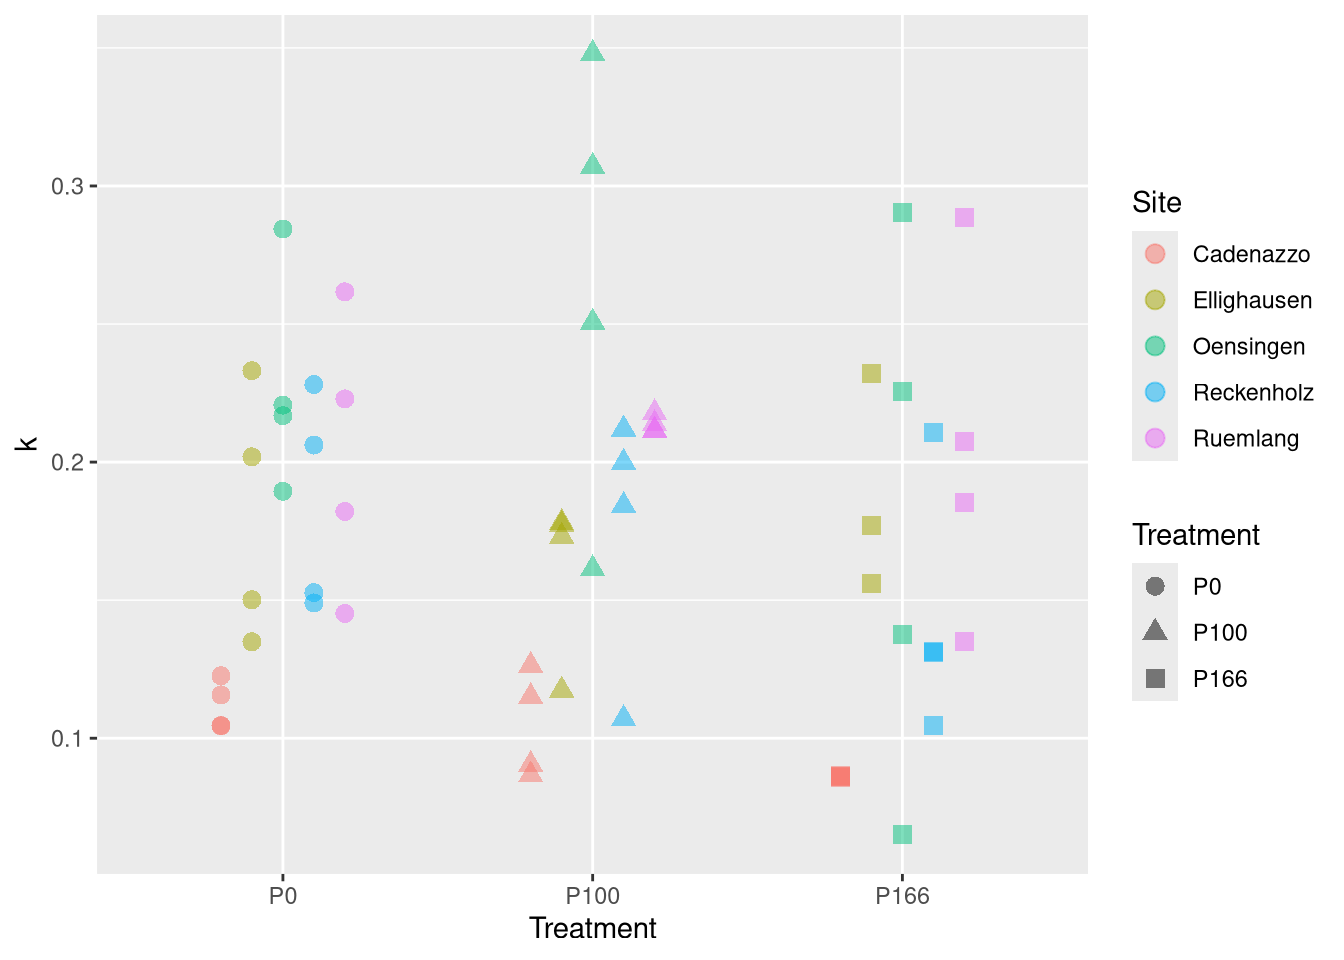

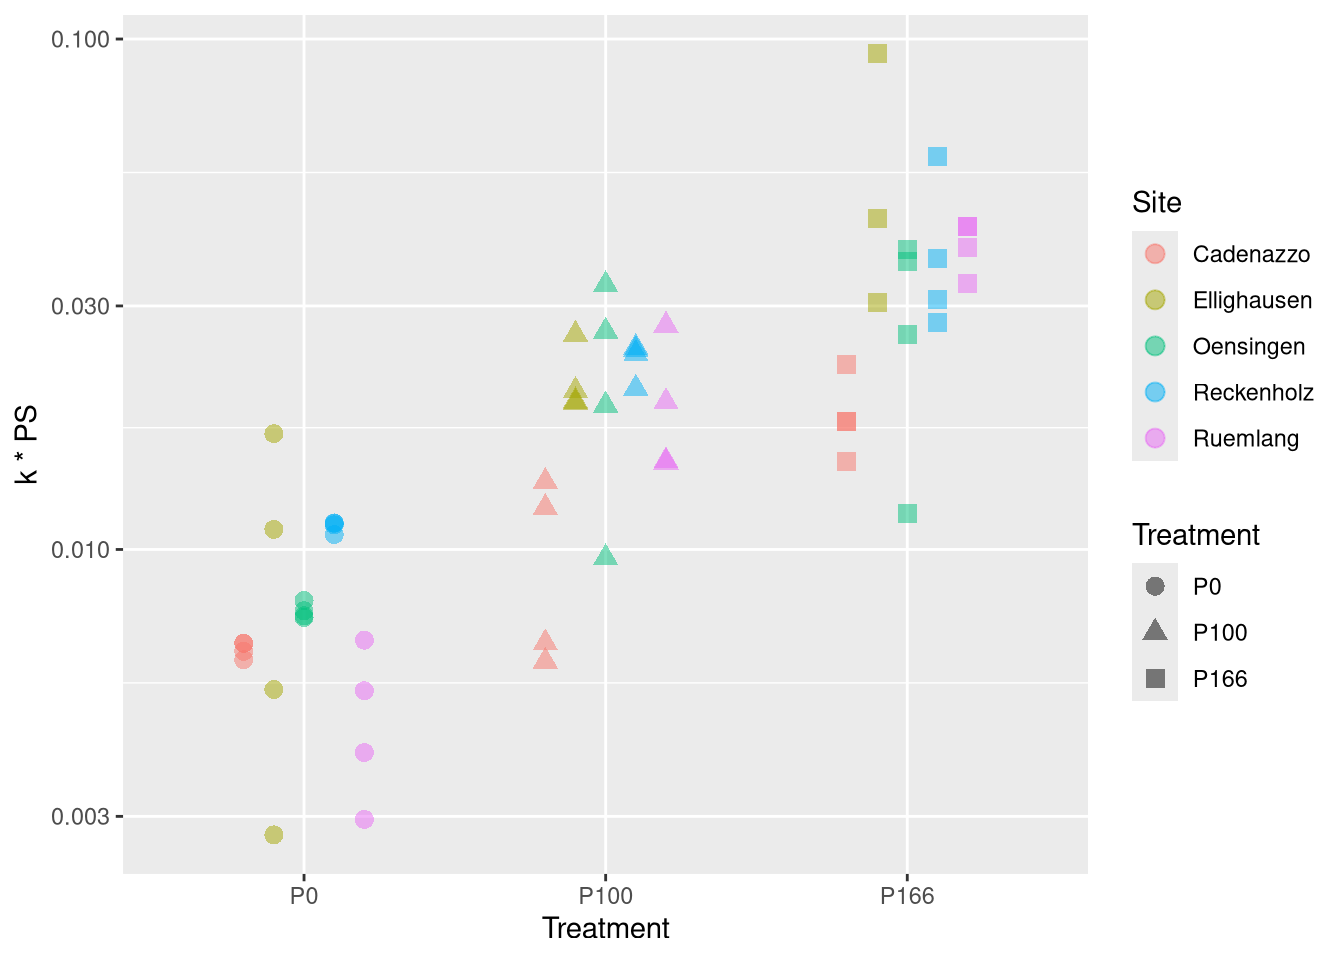

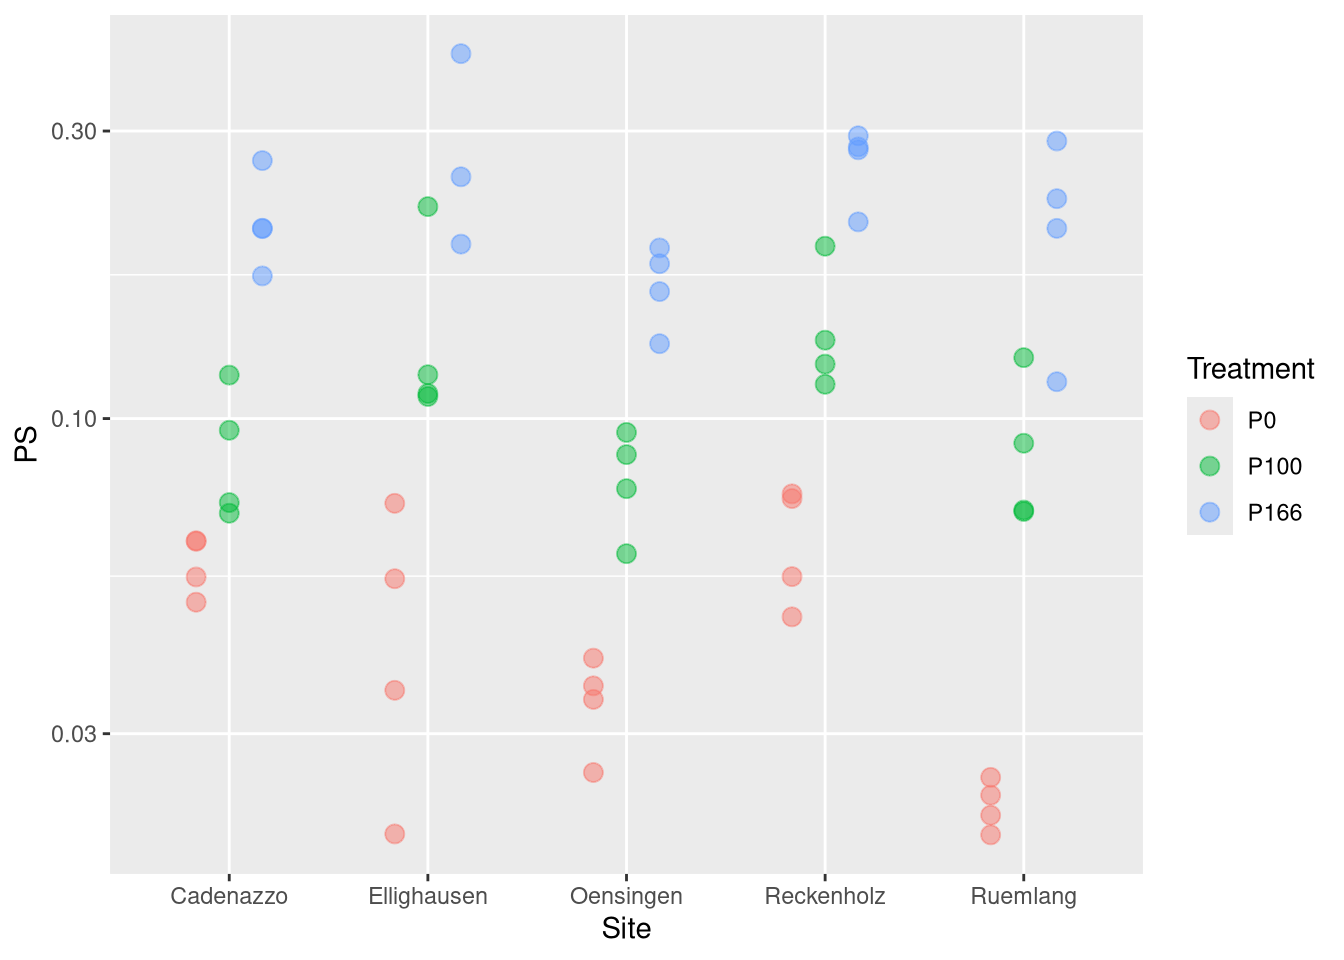

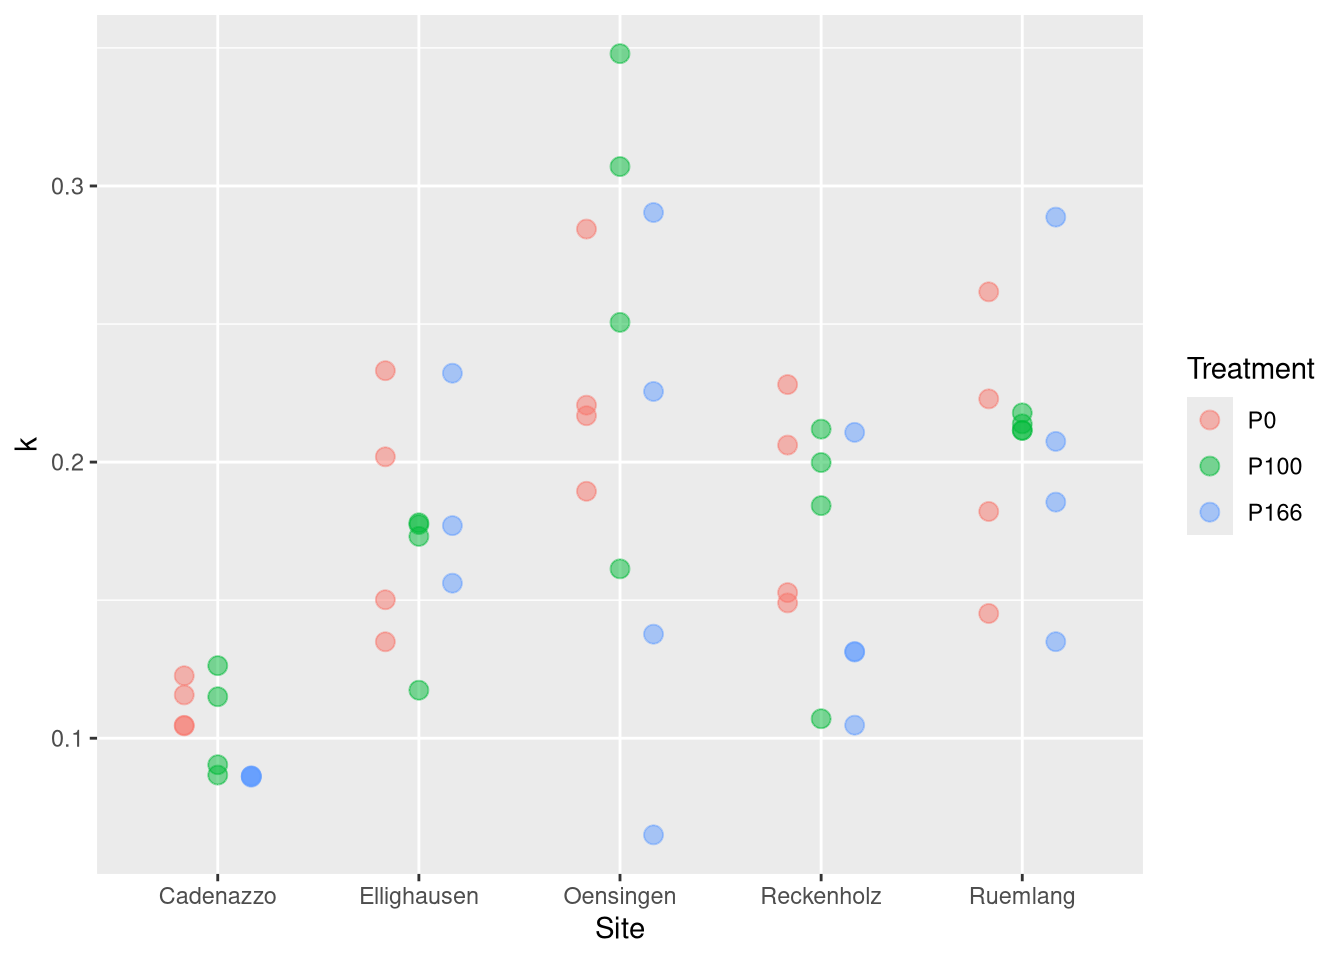

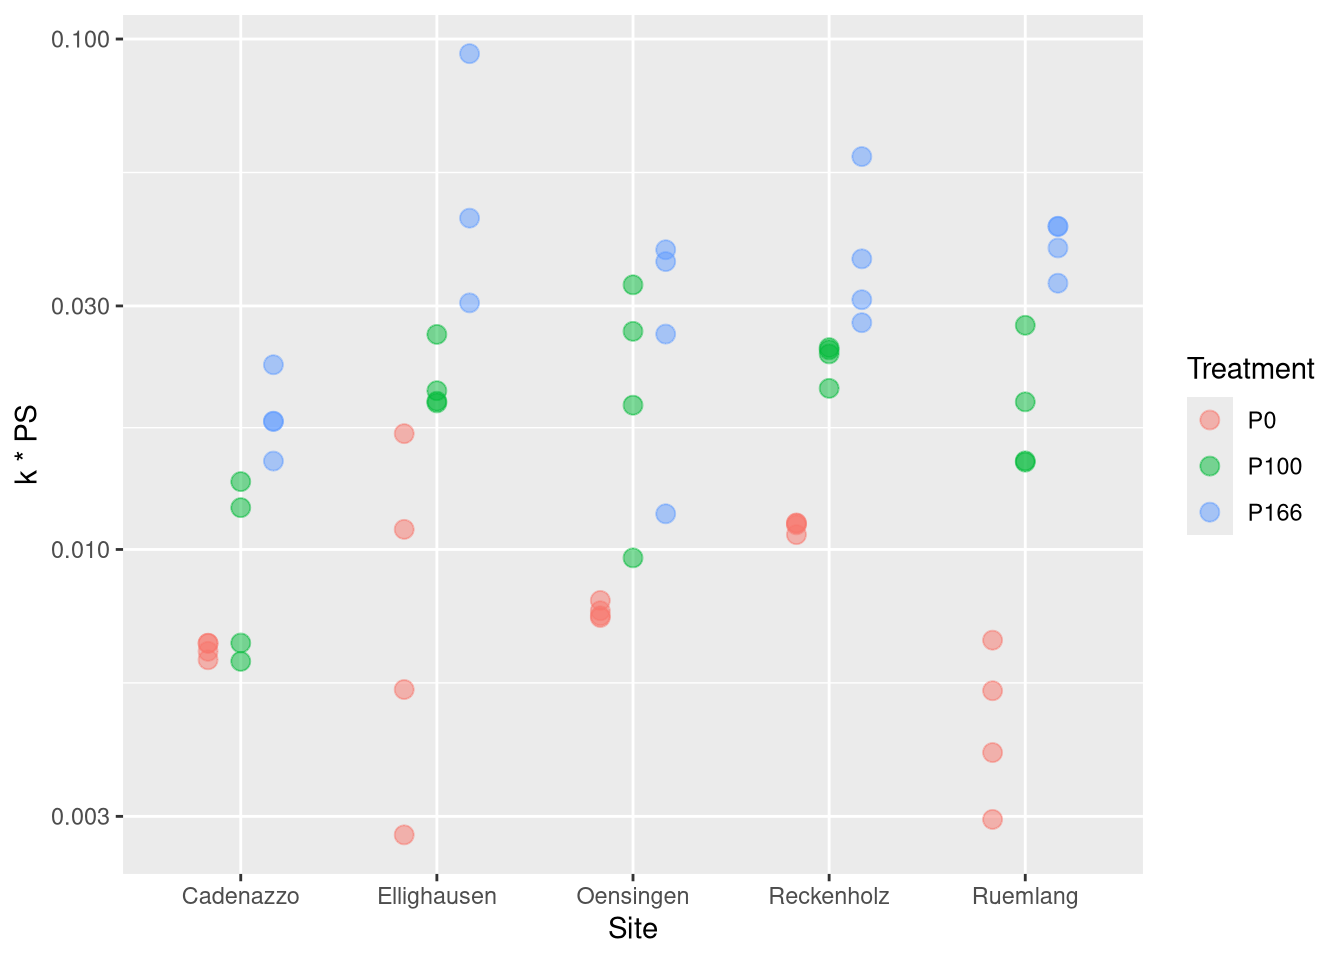

Anova Table (Type II tests)

Response: log(PS)
           Sum Sq Df  F value    Pr(>F)    
Treatment 27.6260  2 154.7655 < 2.2e-16 ***
Site       3.0383  4   8.5104 2.324e-05 ***
Residuals  4.6411 52                       
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


     Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = log(PS) ~ Treatment + Site, data = nlme.coef)

Linear Hypotheses:
                 Estimate Std. Error t value Pr(>|t|)    
P100 - P0 == 0    0.91948    0.09447   9.733   <1e-10 ***
P166 - P0 == 0    1.68127    0.09580  17.550   <1e-10 ***
P166 - P100 == 0  0.76179    0.09580   7.952   <1e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)

Anova Table (Type II tests)

Response: k
            Sum Sq Df F value    Pr(>F)    
Treatment 0.007374  2  1.6124    0.2092    
Site      0.108427  4 11.8547 6.442e-07 ***
Residuals 0.118902 52                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


     Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = k ~ Treatment + Site, data = nlme.coef)

Linear Hypotheses:
                  Estimate Std. Error t value Pr(>|t|)
P100 - P0 == 0    0.003111   0.015121   0.206    0.977
P166 - P0 == 0   -0.022243   0.015334  -1.451    0.323
P166 - P100 == 0 -0.025354   0.015334  -1.653    0.233
(Adjusted p values reported -- single-step method)

Anova Table (Type II tests)

Response: I(log(k * PS))
           Sum Sq Df F value    Pr(>F)    
Treatment 22.4177  2 68.5970 2.609e-15 ***
Site       3.9298  4  6.0124 0.0004703 ***
Residuals  8.4969 52                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


     Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = I(log(k * PS)) ~ Treatment + Site, data = nlme.coef)

Linear Hypotheses:
                 Estimate Std. Error t value Pr(>|t|)    
P100 - P0 == 0     0.9127     0.1278   7.140  < 1e-04 ***
P166 - P0 == 0     1.5035     0.1296  11.599  < 1e-04 ***
P166 - P100 == 0   0.5908     0.1296   4.558 0.000114 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)

Type III Analysis of Variance Table with Satterthwaite's method
                   Sum Sq  Mean Sq NumDF  DenDF F value  Pr(>F)  
soil_0_20_clay   0.002083 0.002083     1 38.033  0.0569 0.81272  
soil_0_20_pH_H2O 0.000134 0.000134     1 37.384  0.0037 0.95203  
soil_0_20_Corg   0.161222 0.161222     1 31.905  4.4045 0.04385 *
soil_0_20_silt   0.004846 0.004846     1 38.673  0.1324 0.71793  
Feox             0.001149 0.001149     1  0.347  0.0314 0.91632  
Alox             0.012358 0.012358     1  0.257  0.3376 0.79220  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Type III Analysis of Variance Table with Satterthwaite's method
                    Sum Sq   Mean Sq NumDF  DenDF F value   Pr(>F)   
soil_0_20_clay   0.0118462 0.0118462     1 39.973 10.7210 0.002191 **
soil_0_20_pH_H2O 0.0011812 0.0011812     1 38.291  1.0690 0.307665   
soil_0_20_Corg   0.0090425 0.0090425     1 35.487  8.1836 0.007040 **
soil_0_20_silt   0.0012705 0.0012705     1 10.804  1.1498 0.306956   
Feox             0.0000004 0.0000004     1  0.968  0.0003 0.988186   
Alox             0.0004765 0.0004765     1  1.117  0.4312 0.620552   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Warning in RET$pfunction("adjusted", ...): Completion with error > abseps


     Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = k ~ soil_0_20_clay + soil_0_20_pH_H2O + soil_0_20_Corg + 
    soil_0_20_silt + Feox + Alox + (1 | year) + (1 | Site) + 
    (1 | Site:block) + (1 | Site:Treatment), data = D)

Linear Hypotheses:
                       Estimate Std. Error z value Pr(>|z|)   
(Intercept) == 0       0.608404   0.351212   1.732  0.37810   
soil_0_20_clay == 0   -0.016659   0.005088  -3.274  0.00662 **
soil_0_20_pH_H2O == 0 -0.022256   0.021526  -1.034  0.84753   
soil_0_20_Corg == 0    0.137353   0.048014   2.861  0.02622 * 
soil_0_20_silt == 0    0.004094   0.003818   1.072  0.82657   
Feox == 0              0.001024   0.054815   0.019  1.00000   
Alox == 0             -0.128860   0.196235  -0.657  0.97802   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)

Type III Analysis of Variance Table with Satterthwaite's method
                  Sum Sq Mean Sq NumDF  DenDF F value   Pr(>F)   
soil_0_20_clay   0.27383 0.27383     1 37.930  3.2642 0.078745 . 
soil_0_20_pH_H2O 0.00989 0.00989     1 37.703  0.1179 0.733211   
soil_0_20_Corg   0.63137 0.63137     1 32.625  7.5263 0.009799 **
soil_0_20_silt   0.00591 0.00591     1 39.206  0.0705 0.791988   
Feox             0.04311 0.04311     1  0.225  0.5139 0.775407   
Alox             0.00881 0.00881     1  0.130  0.1050 0.904677   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Warning in RET$pfunction("adjusted", ...): Completion with error > abseps

Warning in RET$pfunction("adjusted", ...): Completion with error > abseps
Warning in RET$pfunction("adjusted", ...): Completion with error > abseps


     Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = I(log(k * PS)) ~ soil_0_20_clay + soil_0_20_pH_H2O + 
    soil_0_20_Corg + soil_0_20_silt + Feox + Alox + (1 | year) + 
    (1 | Site) + (1 | Site:block) + (1 | Site:Treatment), data = D)

Linear Hypotheses:
                      Estimate Std. Error z value Pr(>|z|)  
(Intercept) == 0      -5.22214    2.67612  -1.951   0.2526  
soil_0_20_clay == 0   -0.08506    0.04708  -1.807   0.3306  
soil_0_20_pH_H2O == 0 -0.06836    0.19908  -0.343   0.9993  
soil_0_20_Corg == 0    1.29047    0.47039   2.743   0.0367 *
soil_0_20_silt == 0   -0.01141    0.04296  -0.266   0.9998  
Feox == 0              0.24813    0.34612   0.717   0.9670  
Alox == 0              0.36766    1.13436   0.324   0.9995  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)

In [ ]:

d$ui <- interaction(d$Site, d$Treatment)

nlme.coef.avg <- list()
nlme.coef <- list()
for (lvl in levels(d$ui)){
  d.tmp <- subset(d, ui == lvl)
  # first get nlsList coefs for comparison only (unused)
  temp_nls <- coef(nlsList(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)) | uid, 
                    d.tmp[, c("Pv.mg.L.", "uid", "t.dt")], 
                    start = list(PS = 0.1, k = 0.2)))
  nlsList_coefs <- c(apply(temp_nls, 2, \(x) c(mean=mean(x), sd=sd(x))))
  names(nlsList_coefs) <- c("PS.mean", "PS.sd", "k.mean", "k.sd")

  # now do the real thing
  model4 <- nlme(Pv.mg.L. ~ PS * (1 - exp(-k * t.dt)),
                fixed = PS + k ~ 1,
                random = PS + k  ~ 1 | uid,
                data = d.tmp[, c("Pv.mg.L.", "uid", "t.dt")],
                start = c(PS = 0.05, k = 0.12),
                control = nlmeControl(maxIter = 200))
  coef(model4)
  fixef <- model4$coefficients$fixed
  ranefs <- ranef(model4)
  colnames(ranefs) <- paste0("ranef_",colnames(ranefs))
  nlme.coef[[lvl]]  <- cbind(coef(model4), ranefs, Rep=1:nrow(ranef(model4)), ui=lvl, Site=d.tmp[1, "Site"], Treatment=d.tmp[1, "Treatment"], uid = rownames(coef(model4)))
  nlme.coef.avg[[lvl]] <- data.frame(PS=fixef["PS"], k=fixef["k"], ui=lvl, Site=d.tmp[1, "Site"], Treatment=d.tmp[1, "Treatment"], uid = d.tmp$uid)
}


In [ ]:
library(knitr)
library(kableExtra)

benchmark_results <- readRDS("cache/benchmark-tables.rds")

# Extract individual tables
Tables_yield <- benchmark_results$Tables_yield
Tables_yield_weather <- benchmark_results$Tables_yield_weather
Tables_earth_treatment <- benchmark_results$Tables_earth_treatment
Tables_earth_notreatment <- benchmark_results$Tables_earth_notreatment
Tables_yield_lm <- benchmark_results$Tables_yield_lm
Tables_yield_weather_lm <- benchmark_results$Tables_yield_weather_lm
Tables_earth_lm <- benchmark_results$Tables_earth_lm


In [ ]:
kable(Tables_yield_lm, 
     caption = "Linear model performance for predicting yield and P-balance variables using different P-dynamics variable sets (without weather data). Rows represent different predictor variable sets: 'k' uses only the release rate constant; 'PS' uses only log-transformed semi-labile P; 'kPS' uses both k and log-transformed PS plus their interaction; 'AAE10' uses only log-transformed AAE10-extractable P; 'CO2' uses only log-transformed CO2-extractable P; 'AAE10_CO2' uses both log-transformed AAE10 and CO2 extractable P plus their log-log interaction; 'AAE10_CO2_kPS' combines AAE10, CO2, k, and PS variables with interactions; 'CO2_kPS' combines CO2, k, and PS variables with interactions. Columns show explained variance for different target variables.",
     digits = 3) |>
 kable_styling(bootstrap_options = c("striped", "hover", "condensed"), 
               full_width = FALSE)


                    Ymain_norm   Ymain_rel   annual_P_uptake   annual_P_balance
  --------------- ------------ ----------- ----------------- ------------------
  k                      0.021      -0.009            -0.005              0.018
  PS                     0.223       0.051             0.034              0.553
  kPS                    0.215       0.036             0.030              0.540
  AAE10                  0.109       0.152             0.095              0.277
  CO2                    0.228       0.105             0.075              0.500
  AAE10_CO2              0.232       0.129             0.097              0.491
  AAE10_CO2_kPS          0.233       0.139             0.049              0.562
  CO2_kPS                0.232       0.094             0.046              0.561

  : Linear model performance for predicting yield and P-balance
  variables using different P-dynamics variable sets (without weather
  data). Rows represent different predictor variable sets: \'k\' uses
  only the release rate constant; \'PS\' uses only log-transformed
  semi-labile P; \'kPS\' uses both k and log-transformed PS plus their
  interaction; \'AAE10\' uses only log-transformed AAE10-extractable P;
  \'CO2\' uses only log-transformed CO2-extractable P; \'AAE10_CO2\'
  uses both log-transformed AAE10 and CO2 extractable P plus their
  log-log interaction; \'AAE10_CO2_kPS\' combines AAE10, CO2, k, and PS
  variables with interactions; \'CO2_kPS\' combines CO2, k, and PS
  variables with interactions. Columns show explained variance for
  different target variables.


In [ ]:
kable(Tables_yield_weather_lm, 
      caption = "Linear model performance for predicting yield and P-balance variables including weather data. Rows represent different predictor variable sets: 'onlyweather' uses only weather variables (annual average temperature, annual sum precipitation, juvenile deviation precipitation/sun/temperature, annual sum sun, plus NA weather indicator); 'k' combines weather variables with release rate constant; 'PS' combines weather variables with log-transformed semi-labile P; 'kPS' combines weather variables with k, log-transformed PS, and their interaction; 'AAE10' combines weather variables with log-transformed AAE10-extractable P; 'CO2' combines weather variables with log-transformed CO2-extractable P; 'AAE10_CO2' combines weather variables with both extractable P measures and their interaction; 'AAE10_CO2_kPS' combines weather variables with all P-dynamics parameters; 'CO2_kPS' combines weather variables with CO2, k, and PS parameters.",
      digits = 3) |>
  kable_styling(bootstrap_options = c("striped", "hover", "condensed"), 
                full_width = FALSE)


                    Ymain_norm   Ymain_rel   annual_P_uptake   annual_P_balance
  --------------- ------------ ----------- ----------------- ------------------
  onlyweather           -0.018       0.132             0.391              0.113
  k                      0.023       0.105             0.353              0.077
  PS                     0.204       0.184             0.446              0.627
  kPS                    0.203       0.189             0.415              0.632
  AAE10                  0.147       0.222             0.496              0.432
  CO2                    0.231       0.210             0.463              0.594
  AAE10_CO2              0.235       0.245             0.491              0.591
  AAE10_CO2_kPS          0.220       0.238             0.463              0.652
  CO2_kPS                0.246       0.157             0.449              0.644

  : Linear model performance for predicting yield and P-balance
  variables including weather data. Rows represent different predictor
  variable sets: \'onlyweather\' uses only weather variables (annual
  average temperature, annual sum precipitation, juvenile deviation
  precipitation/sun/temperature, annual sum sun, plus NA weather
  indicator); \'k\' combines weather variables with release rate
  constant; \'PS\' combines weather variables with log-transformed
  semi-labile P; \'kPS\' combines weather variables with k,
  log-transformed PS, and their interaction; \'AAE10\' combines weather
  variables with log-transformed AAE10-extractable P; \'CO2\' combines
  weather variables with log-transformed CO2-extractable P;
  \'AAE10_CO2\' combines weather variables with both extractable P
  measures and their interaction; \'AAE10_CO2_kPS\' combines weather
  variables with all P-dynamics parameters; \'CO2_kPS\' combines weather
  variables with CO2, k, and PS parameters.


In [ ]:
kable(Tables_earth_lm, 
      caption = "Linear model performance comparison for predicting P-dynamics parameters from soil properties. Rows represent different target P-dynamics variables: 'PS_log' is log-transformed semi-labile phosphorus; 'k' is the phosphorus release rate constant; 'kPS_log' is log-transformed product of release rate and semi-labile P; 'P_AAE10_log' is log-transformed AAE10-extractable phosphorus; 'P_CO2_log' is log-transformed CO2-extractable phosphorus. The 'with_treatment' column uses soil variables (clay content, pH, organic carbon, silt content) plus treatment (P0 P100 P166), while 'without_treatment' uses only the soil variables.",
      digits = 3) |>
  kable_styling(bootstrap_options = c("striped", "hover", "condensed"), 
                full_width = FALSE)


                       PS_log       k   kPS_log   P_AAE10_log   P_CO2_log
  ------------------ -------- ------- --------- ------------- -----------
  soil + treatment      0.885   0.328     0.752         0.824       0.792
  only soil             0.042   0.267     0.023         0.365       0.025

  : Linear model performance comparison for predicting P-dynamics
  parameters from soil properties. Rows represent different target
  P-dynamics variables: \'PS_log\' is log-transformed semi-labile
  phosphorus; \'k\' is the phosphorus release rate constant; \'kPS_log\'
  is log-transformed product of release rate and semi-labile P;
  \'P_AAE10_log\' is log-transformed AAE10-extractable phosphorus;
  \'P_CO2_log\' is log-transformed CO2-extractable phosphorus. The
  \'with_treatment\' column uses soil variables (clay content, pH,
  organic carbon, silt content) plus treatment (P0 P100 P166), while
  \'without_treatment\' uses only the soil variables.
